# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Техническая часть

In [1]:
# добавим элементы форматирования
class color:
   BOLD = '\033[1m'
   GREEN = '\033[92m'
   RED = '\033[91m'
   END = '\033[0m'

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

## Знакомство с данными и изучение общей информации

In [3]:
df = pd.read_csv('real_estate_data.csv', sep='\t')

In [4]:
# выведем общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

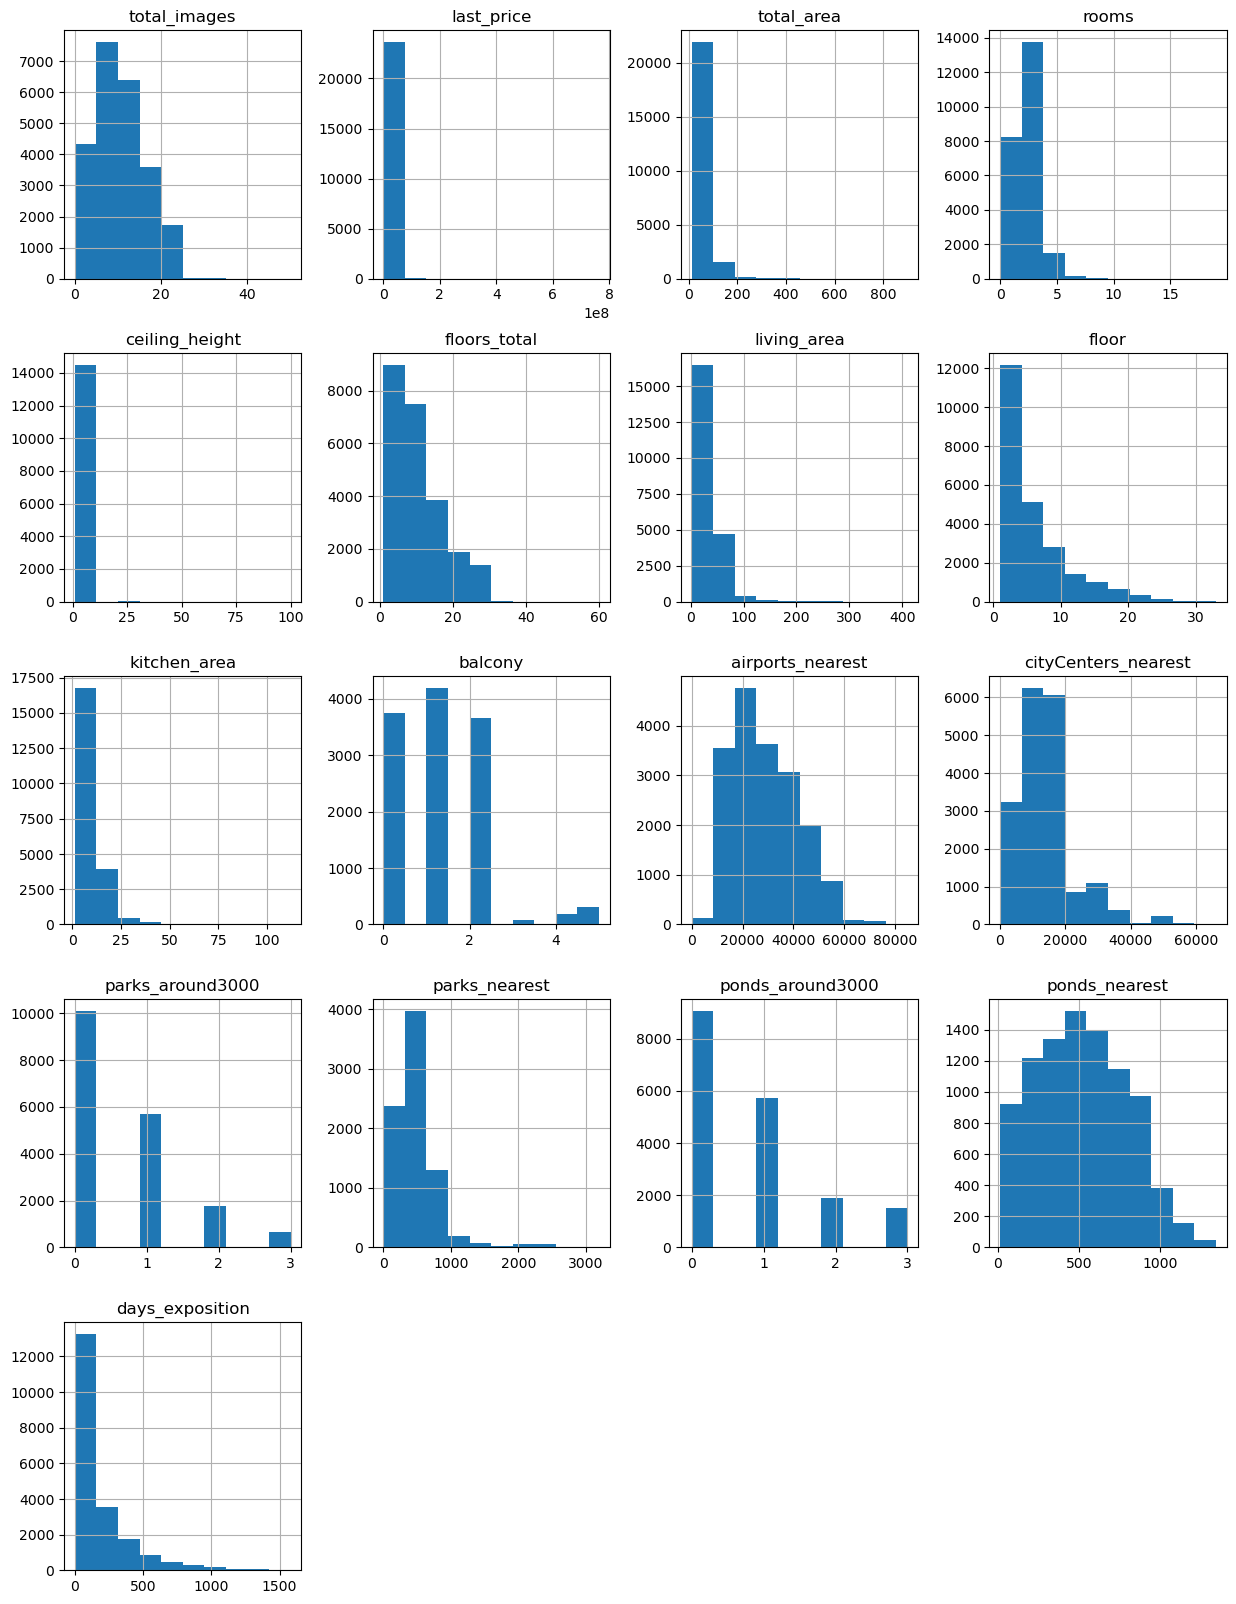

In [5]:
# построим гистограммы для каждой числовой переменной
df.hist(figsize=(15, 20));

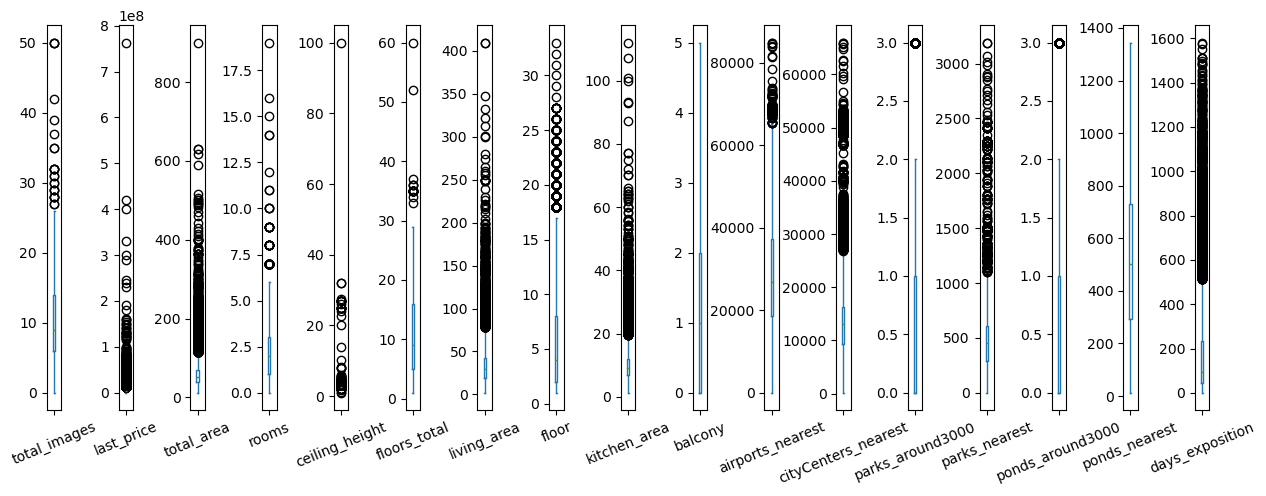

In [6]:
# выведем на экран диаграммы "ящик с усами" для каждой числовой переменной, чтобы лучше увидеть выбросы
(df.plot(kind='box',
       subplots=True,
       figsize=(15, 5),
       rot=22.5
      )
);

# увеличим расстояние между диаграммами, чтобы подпись осей одной диаграммы не перекрывала область другой диаграммы
plt.subplots_adjust(wspace=4)

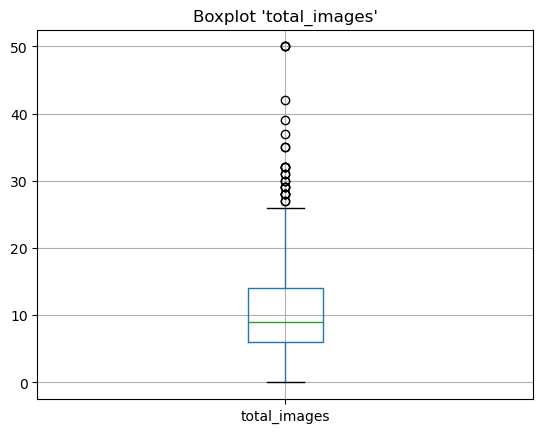

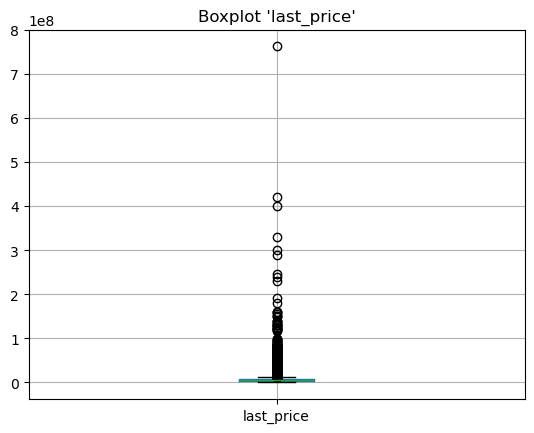

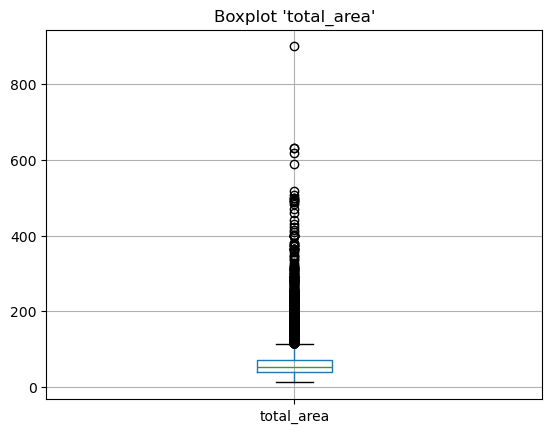

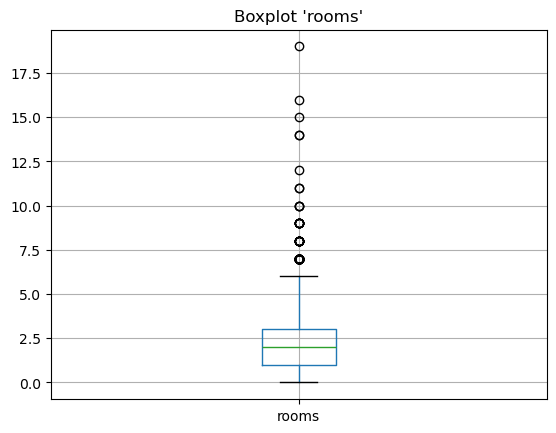

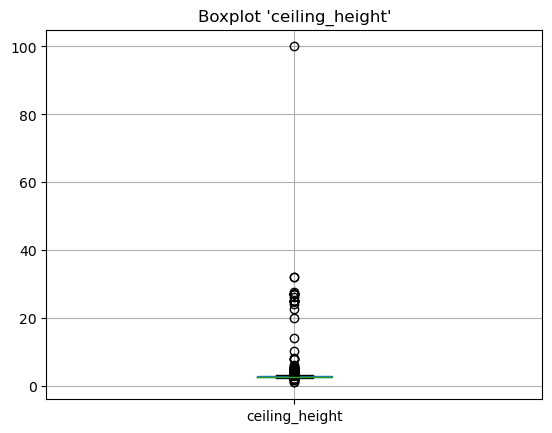

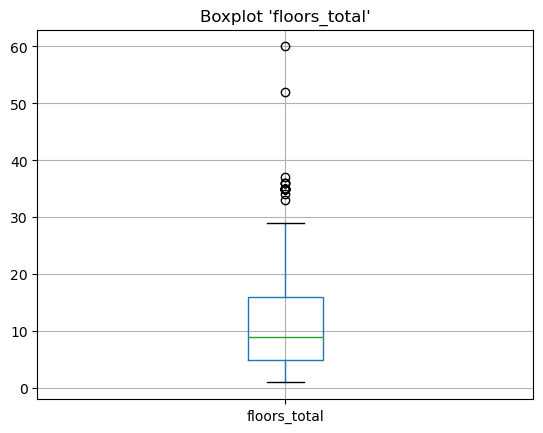

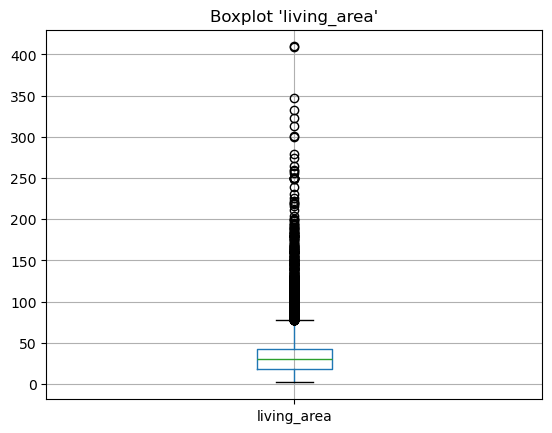

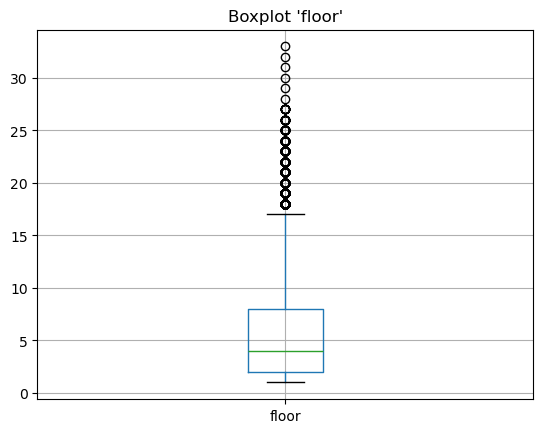

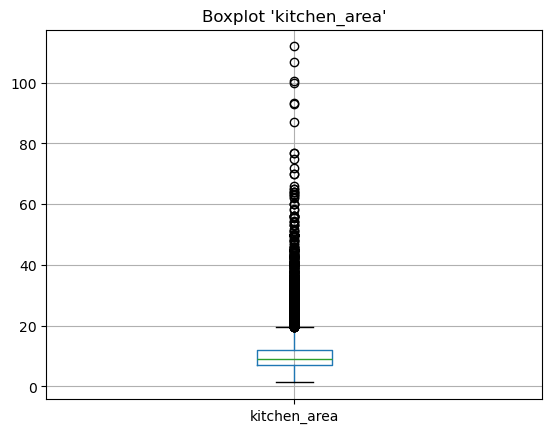

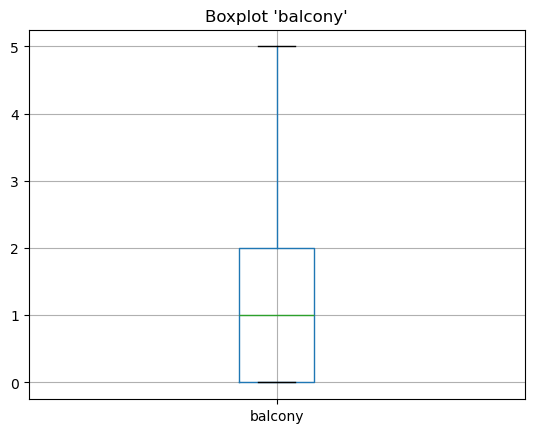

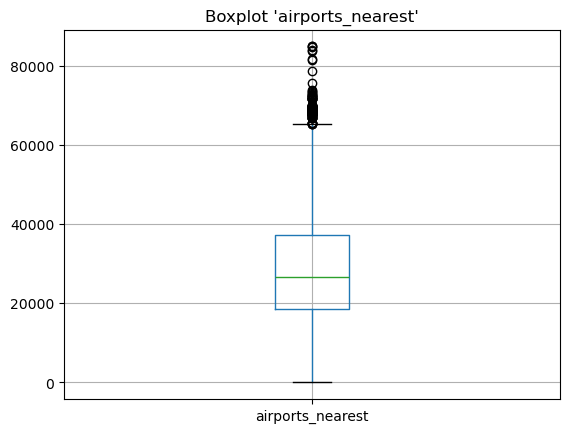

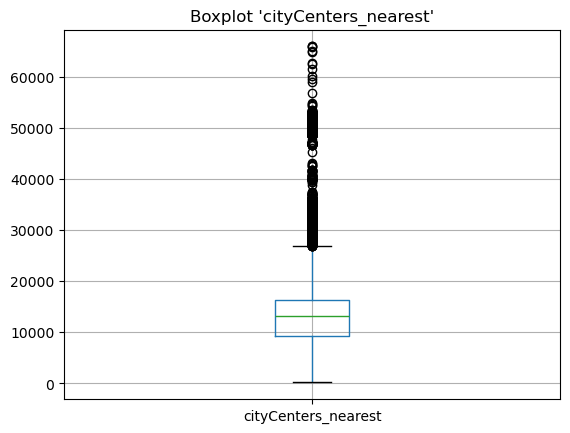

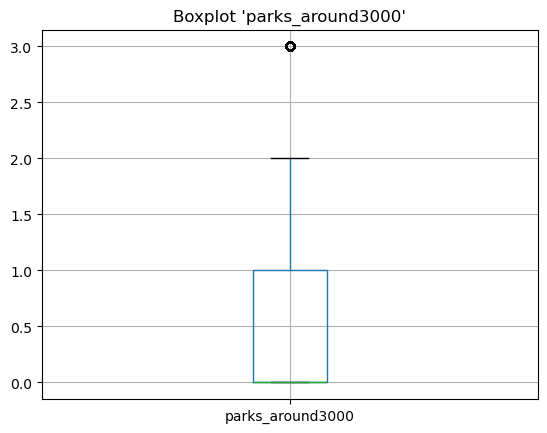

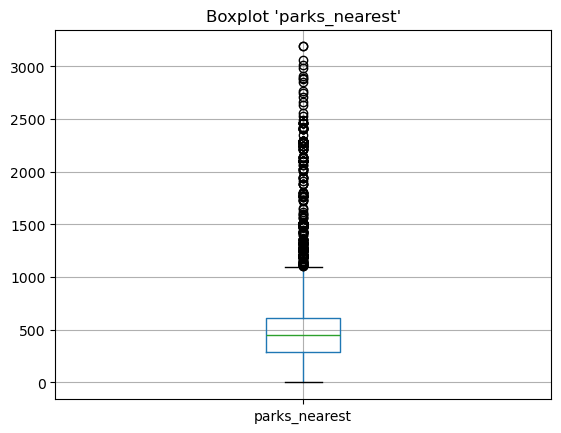

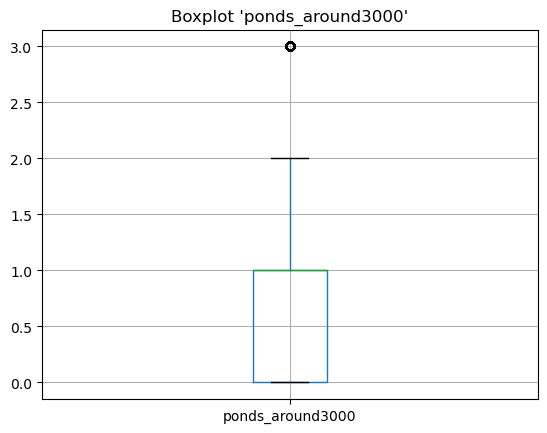

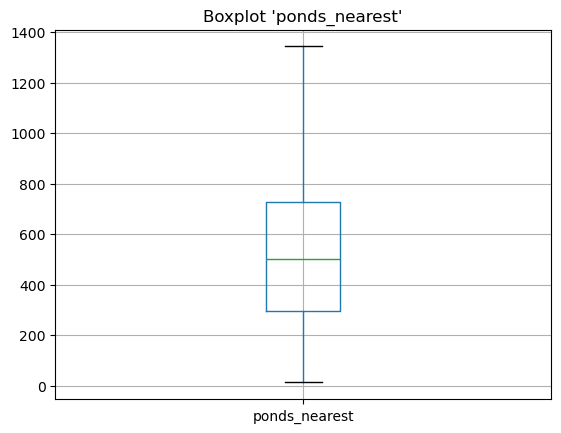

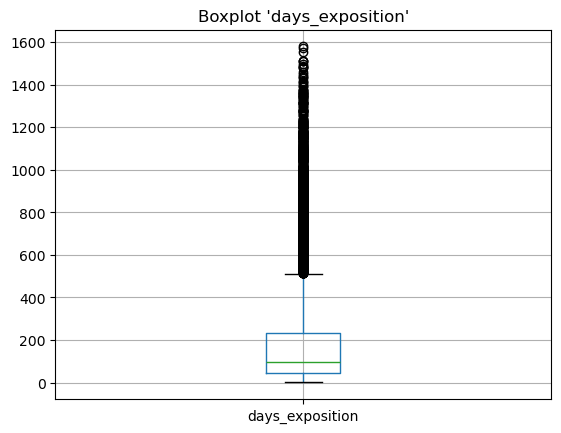

In [7]:
# рассмотрим диаграммы в более крупном виде
for column in df.select_dtypes(include=['int64','float64']):
    plt.figure()
    plt.title(f"Boxplot '{column}'")
    df.boxplot([column])

## Предобработка данных ###

In [8]:
# переименуем переменные в соответствии с хорошим стилем
df = df.rename(columns={'cityCenters_nearest':'city_centers_nearest',
                        'parks_around3000':'parks_around_3000',
                        'ponds_around3000':'ponds_around_3000'})

### Обработка пропусков

**Определение пропусков**

In [9]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around_3000        5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [10]:
# выведем доли пропусков по столбцам
percent_missing = (df.isnull().sum() * 100 / len(df)).map("{:.0f}%".format)
percent_missing[percent_missing != '0%']

ceiling_height          39%
living_area              8%
is_apartment            88%
kitchen_area            10%
balcony                 49%
airports_nearest        23%
city_centers_nearest    23%
parks_around_3000       23%
parks_nearest           66%
ponds_around_3000       23%
ponds_nearest           62%
days_exposition         13%
dtype: object

**Заполнение пропущенных значений**

In [11]:
df.groupby('ceiling_height', dropna=False).count()

# пропусков много, но данных для их заполнения нет, поэтому строки с пропусками оставляем

,total_images,last_price,total_area,first_day_exposition,rooms,floors_total,living_area,floor,is_apartment,studio,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
ceiling_height,,,,,,,,,,,,,,,,,,,,,
1.00,1,1,1,1,1,1,1,1,0,1,...,1,0,1,1,1,1,1,1,1,1
1.20,1,1,1,1,1,1,1,1,0,1,...,1,0,1,0,0,0,0,0,0,1
1.75,1,1,1,1,1,1,1,1,0,1,...,1,0,1,1,1,1,0,1,1,1
2.00,11,11,11,11,11,11,9,11,1,11,...,9,4,11,3,3,3,2,3,2,8
2.20,1,1,1,1,1,1,1,1,0,1,...,1,1,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27.00,8,8,8,8,8,8,8,8,4,8,...,6,7,8,3,3,3,0,3,2,7
27.50,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,0,1
32.00,2,2,2,2,2,2,2,2,1,2,...,2,1,2,1,1,1,0,1,1,0


Возможные причины пропусков в 'ceiling_height': нежелание продавца заполнять этот раздел; ограничения формы заполнения, приведшие к непониманию продавца

In [12]:
df.groupby('floors_total', dropna=False).count()
df.pivot_table(values='floor',
               index='floors_total',
               aggfunc='mean',
               dropna=False)

,floor
floors_total,
1.0,1.000000
2.0,1.498695
3.0,2.023952
4.0,2.603333
5.0,3.061161
6.0,3.585339
7.0,4.197635
8.0,4.456410
9.0,4.896570


In [13]:
# пропусков немного, данных для их заполнения нет, поэтому строки с пропусками удаляем
df = df.dropna(subset=['floors_total'])

Возможные причины пропусков в 'floors_total': невнимательность продавца при заполнении формы

In [14]:
# пропусков немного, данных для их заполнения нет, поэтому строки с пропусками удаляем
df = df.dropna(subset=['floors_total'])

In [15]:
df[['total_area', 'living_area' , 'kitchen_area']].sort_values(by='living_area', ascending=False)
# пропусков много, но данных для их заполнения нет, поэтому строки с пропусками оставляем

,total_area,living_area,kitchen_area
19540,900.00,409.7,112.0
5358,590.00,409.0,100.0
12401,495.00,347.5,25.0
4237,517.00,332.0,22.0
12859,631.20,322.3,19.5
...,...,...,...
23642,80.30,NaN,NaN
23663,88.00,NaN,NaN
23670,45.60,NaN,NaN
23679,35.00,NaN,NaN


Возможные причины пропусков в 'living_area' и 'kitchen_area': отсутствие данных у продавца

In [16]:
display(df.groupby('is_apartment', dropna=False).count())
df.pivot_table(values='last_price',
               index=['is_apartment', 'rooms'],
               aggfunc='count',
               dropna=False)

# логики пропусков не заметил, все пропуски оставляем как есть

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
is_apartment,,,,,,,,,,,,,,,,,,,,,
NaN,20838,20838,20838,20838,20838,12633,20838,19088,20838,20838,...,18797,9835,20805,15937,15957,15958,7098,15958,7985,17941
False,2725,2725,2725,2725,2725,1818,2725,2613,2725,2725,...,2550,2267,2710,2103,2104,2104,928,2104,1046,2462
True,50,50,50,50,50,44,50,42,50,50,...,35,31,50,41,43,43,19,43,30,38


last_price
is_apartment rooms            
NaN          0           188.0
             1          7088.0
             2          6962.0
             3          5114.0
             4          1027.0
             5           276.0
             6            98.0
             7            55.0
             8            12.0
             9             7.0
             10            3.0
             11            2.0
             12            1.0
             14            2.0
             15            1.0
             16            1.0
             19            1.0
False        0             6.0
             1           907.0
             2           938.0
             3           667.0
             4           149.0
             5            48.0
             6             6.0
             7             3.0
             8             NaN
             9             1.0
             10            NaN
             11            NaN
             12            NaN
             14            NaN
             15            NaN
             16            NaN
             19            NaN
True         0             NaN
             1            20.0
             2            13.0
             3            14.0
             4             1.0
             5             1.0
             6             NaN
             7             1.0
             8             NaN
             9             NaN
             10            NaN
             11            NaN
             12            NaN
             14            NaN
             15            NaN
             16            NaN
             19            NaN

Возможные причины пропусков в 'is_apartment': непонимание, что такое апартаменты

In [17]:
# в переменной 'balcony' заменим пропуски на 0 (балкон отсутствует)
df['balcony'] = df.loc[:,'balcony'].fillna(0)

Возможные причины пропусков в 'balcony': невнимательность; мнение, что отказ от указания балкона означает отсутствие балкона

In [18]:
df.groupby('locality_name', dropna=False).count()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,open_plan,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
locality_name,,,,,,,,,,,,,,,,,,,,,
Бокситогорск,16,16,16,16,16,2,16,10,16,3,...,16,11,16,0,0,0,0,0,0,14
Волосово,36,36,36,36,36,19,36,35,36,2,...,36,35,36,0,0,0,0,0,0,31
Волхов,111,111,111,111,111,58,111,92,111,7,...,111,97,111,0,0,0,0,0,0,85
Всеволожск,398,398,398,398,398,272,398,371,398,44,...,398,357,398,0,0,0,0,0,0,339
Выборг,237,237,237,237,237,98,237,193,237,32,...,237,201,237,0,0,0,0,0,0,208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
село Рождествено,3,3,3,3,3,0,3,3,3,0,...,3,2,3,0,0,0,0,0,0,2
село Русско-Высоцкое,9,9,9,9,9,5,9,8,9,0,...,9,8,9,0,0,0,0,0,0,8
село Старая Ладога,2,2,2,2,2,0,2,1,2,0,...,2,1,2,0,0,0,0,0,0,1


In [19]:
# пропусков мало, можно удалить
df = df.dropna(subset=['locality_name'])

Возможные причины пропусков в 'locality_name': отсутствия названия населённого пункта на карте Яндекса

In [20]:
map_variables = ['airports_nearest',
                 'city_centers_nearest',
                 'parks_around_3000',
                 'parks_nearest',
                 'ponds_around_3000',
                 'ponds_nearest']

df.pivot_table(values=map_variables,
               index='locality_name',
               aggfunc='mean',
               dropna=True)

,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest
locality_name,,,,,,
Зеленогорск,73300.250000,54617.583333,1.916667,210.625000,0.875000,485.888889
Колпино,26375.863501,32113.771513,0.522255,495.481203,0.997033,532.268421
Красное Село,26610.028736,30034.741379,0.482759,468.400000,0.091954,445.500000
Кронштадт,67469.263158,49195.726316,1.789474,324.574713,1.936842,343.413793
Ломоносов,48308.280303,50739.969697,0.242424,389.062500,1.128788,550.048193
Павловск,21053.342105,33206.921053,1.552632,379.538462,1.842105,493.382353
Петергоф,40184.676617,35468.925373,1.338308,419.559441,1.308458,513.367521
Пушкин,16447.869919,28745.375000,0.747967,404.297170,0.872629,482.988701
Санкт-Петербург,28040.281621,11588.493939,0.627606,498.338298,0.770188,520.391129


Возможные причины пропусков в картографических переменных: интеграция с Яндекс Картами не закончилась

In [21]:
df.pivot_table(values='days_exposition',
               index='first_day_exposition',
               aggfunc='mean',
               dropna=False)

# дата выгрузки данных — 2 мая 2019 года,
# но пропуски есть как в начале, так и в конце данных,
# так что мы не знаем, какие объявления ещё активны,
# и не можем использовать дату выгрузки —
# поэтому оставим пропуски

,days_exposition
first_day_exposition,
2014-11-27T00:00:00,982.937500
2014-11-29T00:00:00,591.000000
2014-12-04T00:00:00,994.500000
2014-12-05T00:00:00,581.000000
2014-12-08T00:00:00,842.142857
...,...
2019-04-29T00:00:00,2.000000
2019-04-30T00:00:00,2.000000
2019-05-01T00:00:00,1.000000


Возможные причины пропусков в 'days_exposition': техническая ошибка

#### Результаты обработки пропусков

In [22]:
print(df.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9084
floors_total                0
living_area              1865
floor                       0
is_apartment            20805
studio                      0
open_plan                   0
kitchen_area             2222
balcony                     0
locality_name               0
airports_nearest         5524
city_centers_nearest     5501
parks_around_3000        5500
parks_nearest           15535
ponds_around_3000        5500
ponds_nearest           14529
days_exposition          3171
dtype: int64


Справочно до обработки пропусков:
+ ceiling_height           9195
+ floors_total               86
+ living_area              1903
+ is_apartment            20924
+ kitchen_area             2278
+ balcony                 11519
+ locality_name              49
+ airports_nearest         5542
+ city_centers_nearest     5519
+ parks_around_3000        5518
+ parks_nearest           15620
+ ponds_around_3000        5518
+ ponds_nearest           14589
+ days_exposition          3181

### Изменение типов данных

In [23]:
# выведем уникальные отсортированные данные для каждой переменной,
# чтобы определить потребность в изменении типов данных, устранении дубликатов и выбросов
for col in df:
    print(color.BOLD, col, '|', 'Пропуски:', color.RED, df[col].isna().sum(), color.END)
    display(df[col].sort_values().unique())

 total_images | Пропуски:  0 


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35,
       37, 39, 42, 50])

 last_price | Пропуски:  0 


array([1.219e+04, 4.300e+05, 4.400e+05, ..., 4.013e+08, 4.200e+08,
       7.630e+08])

 total_area | Пропуски:  0 


array([ 12. ,  13. ,  13.2, ..., 631. , 631.2, 900. ])

 first_day_exposition | Пропуски:  0 


array(['2014-11-27T00:00:00', '2014-11-29T00:00:00',
       '2014-12-04T00:00:00', ..., '2019-05-01T00:00:00',
       '2019-05-02T00:00:00', '2019-05-03T00:00:00'], dtype=object)

 rooms | Пропуски:  0 


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 19])

 ceiling_height | Пропуски:  9084 


array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

 floors_total | Пропуски:  0 


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 33., 34., 35., 36., 37., 52., 60.])

 living_area | Пропуски:  1865 


array([  2. ,   3. ,   5. , ..., 409. , 409.7,   nan])

 floor | Пропуски:  0 


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

 is_apartment | Пропуски:  20805 


array([False, True, nan], dtype=object)

 studio | Пропуски:  0 


array([False,  True])

 open_plan | Пропуски:  0 


array([False,  True])

 kitchen_area | Пропуски:  2222 


array([  1.3 ,   2.  ,   2.3 ,   2.4 ,   2.89,   3.  ,   3.2 ,   3.3 ,
         3.4 ,   3.5 ,   3.7 ,   3.8 ,   4.  ,   4.1 ,   4.2 ,   4.3 ,
         4.4 ,   4.5 ,   4.6 ,   4.7 ,   4.8 ,   4.9 ,   5.  ,   5.04,
         5.06,   5.1 ,   5.14,   5.2 ,   5.21,   5.23,   5.25,   5.28,
         5.29,   5.3 ,   5.31,   5.33,   5.35,   5.4 ,   5.42,   5.44,
         5.47,   5.49,   5.5 ,   5.53,   5.59,   5.6 ,   5.61,   5.62,
         5.64,   5.65,   5.68,   5.7 ,   5.74,   5.75,   5.78,   5.8 ,
         5.82,   5.85,   5.86,   5.9 ,   5.91,   6.  ,   6.02,   6.03,
         6.1 ,   6.16,   6.19,   6.2 ,   6.22,   6.23,   6.24,   6.25,
         6.26,   6.27,   6.28,   6.3 ,   6.31,   6.33,   6.35,   6.36,
         6.37,   6.4 ,   6.47,   6.5 ,   6.55,   6.58,   6.6 ,   6.61,
         6.62,   6.65,   6.7 ,   6.72,   6.73,   6.76,   6.77,   6.8 ,
         6.82,   6.83,   6.84,   6.86,   6.9 ,   6.91,   6.93,   6.95,
         7.  ,   7.02,   7.03,   7.06,   7.09,   7.1 ,   7.12,   7.15,
      

 balcony | Пропуски:  0 


array([0., 1., 2., 3., 4., 5.])

 locality_name | Пропуски:  0 


array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

 airports_nearest | Пропуски:  5524 


array([    0.,  6450.,  6914., ..., 84853., 84869.,    nan])

 city_centers_nearest | Пропуски:  5501 


array([  181.,   208.,   215., ..., 65952., 65968.,    nan])

 parks_around_3000 | Пропуски:  5500 


array([ 0.,  1.,  2.,  3., nan])

 parks_nearest | Пропуски:  15535 


array([1.000e+00, 3.000e+00, 4.000e+00, 7.000e+00, 9.000e+00, 1.000e+01,
       1.100e+01, 1.200e+01, 1.300e+01, 1.400e+01, 1.500e+01, 1.600e+01,
       1.700e+01, 1.800e+01, 1.900e+01, 2.000e+01, 2.100e+01, 2.200e+01,
       2.300e+01, 2.400e+01, 2.700e+01, 2.800e+01, 3.000e+01, 3.200e+01,
       3.300e+01, 3.400e+01, 3.500e+01, 3.600e+01, 3.700e+01, 3.800e+01,
       3.900e+01, 4.000e+01, 4.100e+01, 4.200e+01, 4.300e+01, 4.400e+01,
       4.500e+01, 4.600e+01, 4.700e+01, 4.800e+01, 4.900e+01, 5.000e+01,
       5.100e+01, 5.200e+01, 5.300e+01, 5.400e+01, 5.500e+01, 5.600e+01,
       5.700e+01, 5.800e+01, 5.900e+01, 6.000e+01, 6.100e+01, 6.200e+01,
       6.300e+01, 6.400e+01, 6.500e+01, 6.600e+01, 6.800e+01, 6.900e+01,
       7.100e+01, 7.200e+01, 7.300e+01, 7.400e+01, 7.500e+01, 7.600e+01,
       7.700e+01, 7.800e+01, 8.000e+01, 8.100e+01, 8.200e+01, 8.300e+01,
       8.400e+01, 8.500e+01, 8.600e+01, 8.700e+01, 8.800e+01, 9.000e+01,
       9.100e+01, 9.200e+01, 9.300e+01, 9.400e+01, 

 ponds_around_3000 | Пропуски:  5500 


array([ 0.,  1.,  2.,  3., nan])

 ponds_nearest | Пропуски:  14529 


array([  13.,   16.,   19., ..., 1341., 1344.,   nan])

 days_exposition | Пропуски:  3171 


array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.572e+03, 1.580e+03,
             nan])

Гипотеза об изменении типа данных:
- из object (ISO 8601) в datetime — *first_day_exposition*,
- из object в bool — *is_apartment*,
- из float64 в int64 — *floors_total*, *balcony*, *airports_nearest*, *city_centers_nearest*, *parks_around_3000*, *parks_nearest*, *ponds_around_3000*, *ponds_nearest*, *days_exposition*.

In [24]:
# изменяем тип данных 'first_day_exposition'
print(color.BOLD + 'BEFORE' + color.END)
display(df['first_day_exposition'])
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

print()
print(color.BOLD + 'AFTER' + color.END)
df['first_day_exposition']

BEFORE


0        2019-03-07T00:00:00
1        2018-12-04T00:00:00
2        2015-08-20T00:00:00
3        2015-07-24T00:00:00
4        2018-06-19T00:00:00
                ...         
23694    2017-03-21T00:00:00
23695    2018-01-15T00:00:00
23696    2018-02-11T00:00:00
23697    2017-03-28T00:00:00
23698    2017-07-21T00:00:00
Name: first_day_exposition, Length: 23565, dtype: object


AFTER


0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
           ...    
23694   2017-03-21
23695   2018-01-15
23696   2018-02-11
23697   2017-03-28
23698   2017-07-21
Name: first_day_exposition, Length: 23565, dtype: datetime64[ns]

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        14481 non-null  float64       
 6   floors_total          23565 non-null  float64       
 7   living_area           21700 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          2760 non-null   object        
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          21343 non-null  float64       
 13  balcony              

### Обработка дубликатов

Гипотеза об устранении дубликатов:
- 'locality_name'

In [26]:
df.duplicated().sum()

# явные дубликаты в данных отсутствуют

0

In [27]:
# обработаем неявные дубликаты 'locality_name'
print(color.BOLD, 'Уникальных значений ДО:',
      df['locality_name'].sort_values().unique().size, color.END)
#print(df['locality_name'].sort_values().unique())

df['locality_name'] = df.loc[:,'locality_name'].str.replace('поселок', 'посёлок')

replacements = {
    'садовое товарищество Приладожский': 'посёлок городского типа Приладожский',
    'деревня Фёдоровское': 'городской посёлок Фёдоровское',
    'деревня Кудрово': 'Кудрово',
    'посёлок Рябово': 'посёлок городского типа Рябово',
    'посёлок станции Вещево': 'посёлок при железнодорожной станции Вещево',
    'посёлок Гарболово': 'деревня Гарболово',
    'посёлок Калитино': 'деревня Калитино',
    'посёлок Рабитицы': 'деревня Рабитицы',
    'посёлок Мурино': 'Мурино',
    'посёлок станции Приветнинское': 'посёлок при железнодорожной станции Приветнинское',
    'городской посёлок Советский': 'посёлок городского типа Советский',
    'городской посёлок Лесогорский': 'посёлок городского типа Лесогорский',
    'городской посёлок Мга': 'посёлок городского типа Мга',
    'городской посёлок Павлово': 'посёлок городского типа Павлово',
    'городской посёлок Большая Ижора': 'посёлок городского типа Большая Ижора'
}

for old_value, new_value in replacements.items():
    df['locality_name'] = df['locality_name'].str.replace(old_value, new_value)

print()
print(color.BOLD, 'Уникальных значений ПОСЛЕ:',
      df['locality_name'].sort_values().unique().size, color.END)
display(df['locality_name'].sort_values().unique())

 Уникальных значений ДО: 364 

 Уникальных значений ПОСЛЕ: 315 


array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Рощино', 'городской посёлок Свирьстрой',
       'городской посёлок Фёдоровское', 'городской посёлок Янино-1',
       'деревня Агалатово', 'деревня Аро', 'деревня Батово',
       'деревня Бегуницы', 'деревня Белогорка', 'деревня Большая В

#### Результаты обработки дубликатов

Явных дубликатов не обнаружено.
Неявные дубликаты в переменной 'locality_name' обработаны.

### Обработка аномальных значений

Гипотеза о наличии выбросов в переменных:
1. total_images,
2. last_price,
3. total_area,
4. rooms
5. ceiling_height,
6. floors_total,
7. living_area,
8. kitchen_area.

Алгоритм действий для количественных переменных:
1. Проверить значения переменных на адекватность и внести в них изменения
2. Применить единый подход к выбросам:
    <br>a. если наблюдения, лежащие за пределами полутора межквартильных интервалов, составляют менее 5% выборки, удаляем их,
    <br>b. если иначе, применяем экспертную оценку.

#### Обработка нелогичных значений

In [28]:
# наблюдение, где высота потолка равна 100 м, удалим
df = df[(df['ceiling_height'] != 100) | (df['ceiling_height'].isna())]

# наблюдения, где высота потолка более 14 м, уменьшим в 10 раз,
# потому что, скорее всего, это ошибка при вводе данных
df.loc[df['ceiling_height'] > 14, 'ceiling_height'] = df['ceiling_height'] / 10

# наблюдения, где высота потолка менее 2.4 м, удалим
df = df[(df['ceiling_height'] >= 2.4) | (df['ceiling_height'].isna())]

In [29]:
# проверим, почему возможен вариант "0 комнат" и создадим сводную таблицу со 'studio'
display(df.pivot_table(values='last_price', index=['studio', 'rooms'], aggfunc='count', dropna=False))

# скорректируем данные в соответствии с логикой: если 0 комнат, то это студия; если студия, то это 0 комнат
df.loc[(df['rooms'] == 0) & (df['studio'] == False), 'studio'] = True
df.loc[(df['rooms'] == 1) & (df['studio'] == True), 'rooms'] = 0

last_price
studio rooms            
False  0            59.0
       1          7984.0
       2          7889.0
       3          5772.0
       4          1172.0
       5           325.0
       6           104.0
       7            59.0
       8            12.0
       9             8.0
       10            3.0
       11            2.0
       12            1.0
       14            2.0
       15            1.0
       16            1.0
       19            1.0
True   0           135.0
       1            11.0
       2             NaN
       3             NaN
       4             NaN
       5             NaN
       6             NaN
       7             NaN
       8             NaN
       9             NaN
       10            NaN
       11            NaN
       12            NaN
       14            NaN
       15            NaN
       16            NaN
       19            NaN

In [30]:
# наблюдение, где расстояние до аэропорта равно 0, удалим
df = df[(df['airports_nearest'] != 0) | (df['airports_nearest'].isna())]

#### Автоматическая обработка выбросов

In [31]:
# создадим функцию, которая удалит выбросы в переменных в соответствии с выбранным подходом
def delete_outliers(data):
    # для функции выберем типы данных и исключим переменные,
    # оставив которые, мы потеряем адекватные данные
    for col in (data.loc[:, ~data.columns.isin(['parks_around_3000',
                                                'ponds_around_3000',
                                                'balcony',
                                                'floor',
                                                'rooms'])
                        ].select_dtypes(include=['int64','float64'])):
        
            # найдём первый и третий квартили и границы "усов"
            q = df[col].quantile([0.25, 0.75])
            upper_bound = q[0.75] + 1.5 * (q[0.75] - q[0.25])
            lower_bound = q[0.25] - 1.5 * (q[0.75] - q[0.25])

            # посчитаем, какой процент выборки лежит вне "усов"
            outliers_count_upper = df[col][df[col] > upper_bound].count()
            outliers_count_lower = df[col][df[col] < lower_bound].count()
            outliers_percentage_upper = outliers_count_upper / df[col].count()
            outliers_percentage_lower = outliers_count_lower / df[col].count()

            if outliers_percentage_upper + outliers_percentage_lower < 0.05:
                data = data[(data[col] <= upper_bound) &
                            (data[col] >= lower_bound) |
                            (data[col].isna())
                            ]
                print(color.BOLD, col, data.shape[0], '|',
                      color.GREEN, 'ГОТОВО!', color.END)
            else:
                print(color.BOLD, col, data.shape[0], '|',
                      color.RED,'ТРЕБУЕТСЯ ЭКСПЕРТНАЯ ОЦЕНКА!', color.END)

            print('Доля выбросов в выборке:',
                  f'{(outliers_percentage_upper + outliers_percentage_lower):.2%}',
                  f'(наблюдений: {(outliers_count_upper + outliers_count_lower)})')
            print()

    return data

df = delete_outliers(df)

 total_images 23515 |  ГОТОВО! 
Доля выбросов в выборке: 0.11% (наблюдений: 25)

 last_price 23515 |  ТРЕБУЕТСЯ ЭКСПЕРТНАЯ ОЦЕНКА! 
Доля выбросов в выборке: 8.67% (наблюдений: 2042)

 total_area 23515 |  ТРЕБУЕТСЯ ЭКСПЕРТНАЯ ОЦЕНКА! 
Доля выбросов в выборке: 5.26% (наблюдений: 1239)

 ceiling_height 23515 |  ТРЕБУЕТСЯ ЭКСПЕРТНАЯ ОЦЕНКА! 
Доля выбросов в выборке: 5.46% (наблюдений: 789)

 floors_total 23484 |  ГОТОВО! 
Доля выбросов в выборке: 0.13% (наблюдений: 31)

 living_area 22718 |  ГОТОВО! 
Доля выбросов в выборке: 3.55% (наблюдений: 770)

 kitchen_area 22718 |  ТРЕБУЕТСЯ ЭКСПЕРТНАЯ ОЦЕНКА! 
Доля выбросов в выборке: 5.54% (наблюдений: 1182)

 airports_nearest 22621 |  ГОТОВО! 
Доля выбросов в выборке: 0.55% (наблюдений: 100)

 city_centers_nearest 22621 |  ТРЕБУЕТСЯ ЭКСПЕРТНАЯ ОЦЕНКА! 
Доля выбросов в выборке: 9.53% (наблюдений: 1721)

 parks_nearest 22318 |  ГОТОВО! 
Доля выбросов в выборке: 3.88% (наблюдений: 311)

 ponds_nearest 22318 |  ГОТОВО! 
Доля выбросов в выборке: 0.00%

#### Ручная обработка выбросов

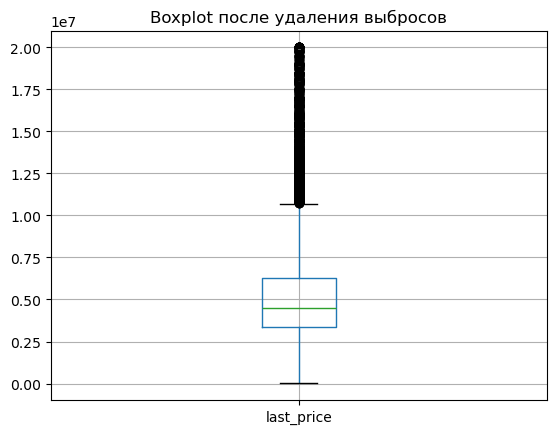

In [32]:
# выведем значения переменной
# display(df.groupby('last_price').count())

# удалим наблюдения, где стоимость квартиры более 20 млн рублей
df = df[(df['last_price'] <= 20000000) |
        (df['last_price'].isna())]
plt.title('Boxplot после удаления выбросов')
df.boxplot('last_price');

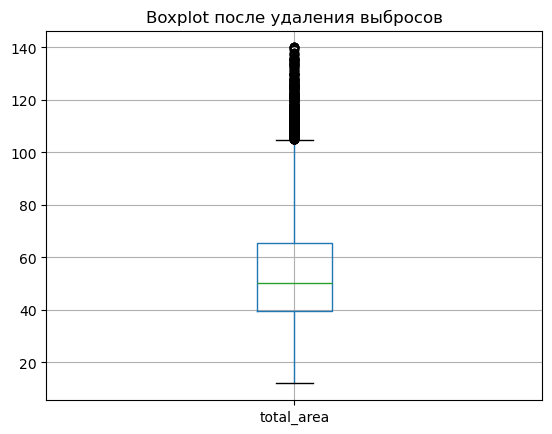

In [33]:
# выведем значения переменной
# display(df.groupby('total_area').count())

# удалим наблюдения, где площадь квартиры более 140 кв. м
df = df[(df['total_area'] <= 140) |
        (df['total_area'].isna())]
plt.title('Boxplot после удаления выбросов')
df.boxplot('total_area');

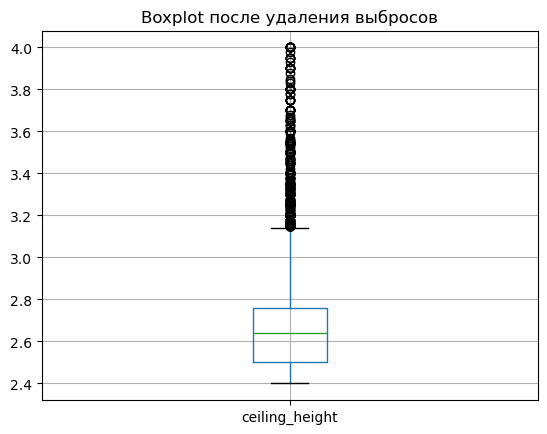

In [34]:
# выведем значения переменной
# display(df.groupby('ceiling_height').count())

# удалим наблюдения, где высота потолка более 4 м
df = df[(df['ceiling_height'] <= 4) |
        (df['ceiling_height'].isna())]
plt.title('Boxplot после удаления выбросов')
df.boxplot('ceiling_height');

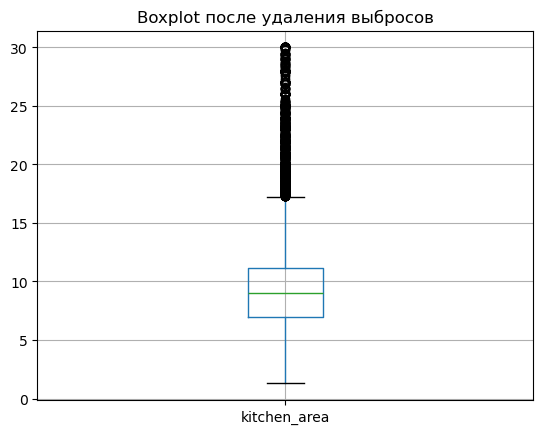

In [35]:
# выведем значения переменной
# display(df.groupby('kitchen_area').count())

# удалим наблюдения, где площадь кухни более 30 м
df = df[(df['kitchen_area'] <= 30) |
        (df['kitchen_area'].isna())]
plt.title('Boxplot после удаления выбросов')
df.boxplot('kitchen_area');

,mean,min,max
,city_centers_nearest,city_centers_nearest,city_centers_nearest
locality_name,,,
Колпино,32084.000000,29436.0,37477.0
Красное Село,30056.482353,27317.0,41792.0
Кронштадт,46874.375000,46657.0,47054.0
Ломоносов,50724.488550,36816.0,61495.0
Павловск,33235.472222,31533.0,36445.0
Петергоф,35417.534759,29815.0,49574.0
Пушкин,28742.863768,24311.0,35610.0
Санкт-Петербург,12021.904637,208.0,29493.0


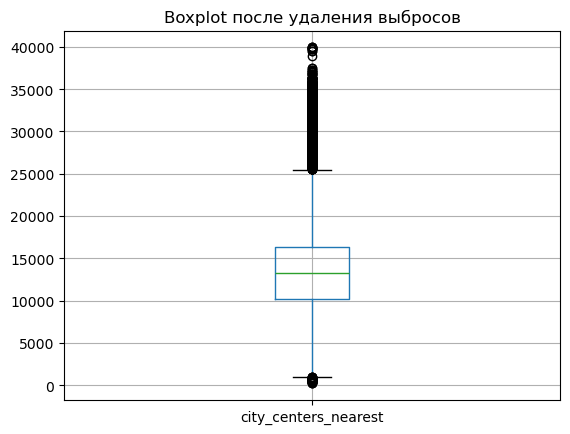

In [36]:
# выведем значения переменной
display(df.pivot_table(values='city_centers_nearest',
                       index='locality_name',
                       aggfunc=['mean', 'min', 'max'],
                       dropna=True)
       )

# удалим наблюдения, где расстояние до центра Санкт-Петербурга более 40 км
# таким образом мы удаляем Кронштадт и Репино из выборки
df = df[(df['city_centers_nearest'] <= 40000) |
        (df['city_centers_nearest'].isna())]
plt.title('Boxplot после удаления выбросов')
df.boxplot('city_centers_nearest');

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest
days_exposition,,,,,,,,,,,,,,,,,,,,,
1.0,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
2.0,3,3,3,3,3,2,3,2,3,1,...,3,2,3,3,3,3,3,1,3,0
3.0,146,146,146,146,146,85,146,141,146,12,...,146,139,146,146,118,118,118,42,118,42
4.0,170,170,170,170,170,102,170,166,170,10,...,170,156,170,170,134,134,134,62,134,58
5.0,144,144,144,144,144,85,144,135,144,10,...,144,129,144,144,117,117,117,50,117,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497.0,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,0
1512.0,1,1,1,1,1,0,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
1513.0,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,0


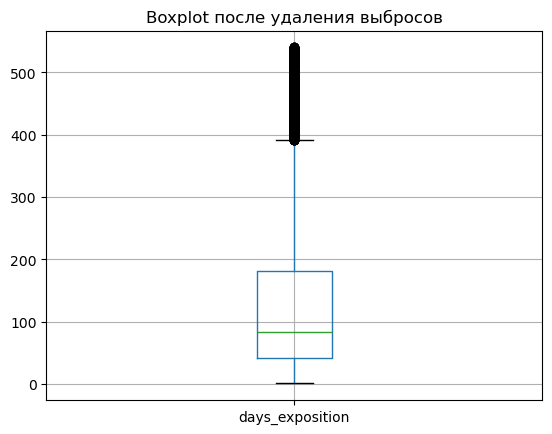

In [37]:
# выведем значения переменной
display(df.groupby('days_exposition').count())

# удалим наблюдения, где квартира была в продаже более 1.5 лет
df = df[(df['days_exposition'] <= 540) |
        (df['days_exposition'].isna())]
plt.title('Boxplot после удаления выбросов')
df.boxplot('days_exposition');

### Результаты предобработки данных

Снова выведем общую информацию о датафрейме, гистограммы и ящики с усами для всех количественных переменных:

In [38]:
# сбросим индекс
df = df.reset_index(drop=True)

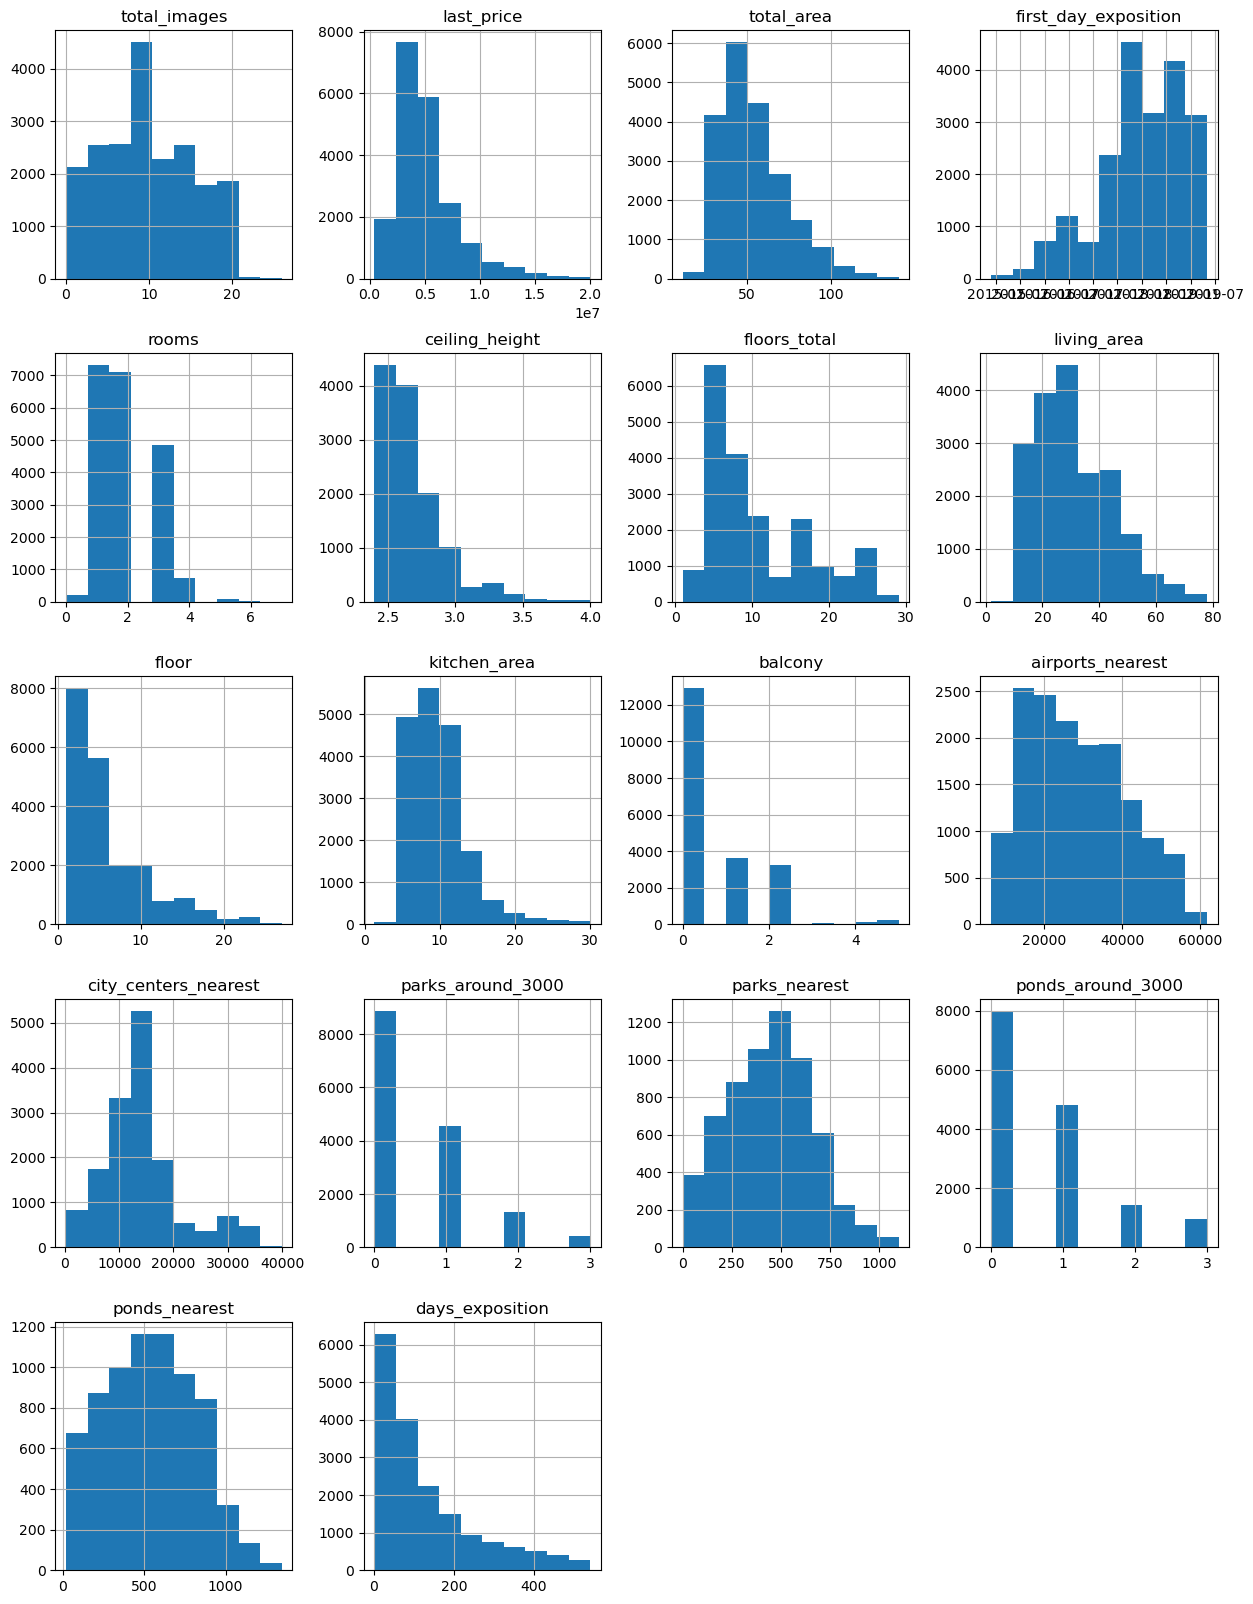

In [39]:
# построим гистограммы для каждой числовой переменной
df.hist(figsize=(15, 20));

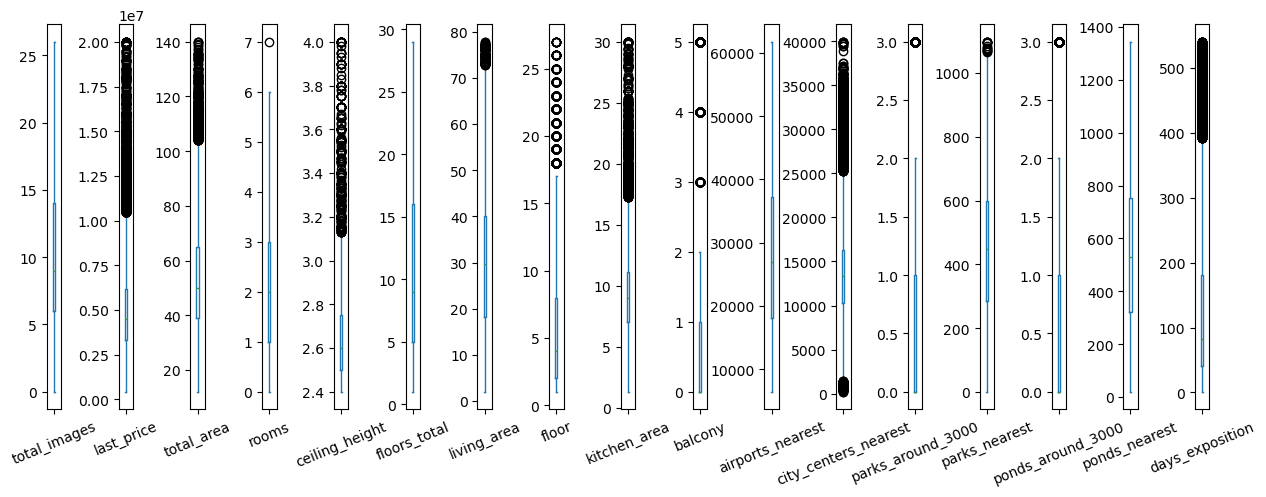

In [40]:
# выведем на экран диаграммы "ящик с усами" для каждой числовой переменной,
# чтобы лучше увидеть выбросы
(df.plot(kind='box',
       subplots=True,
       figsize=(15, 5),
       rot=22.5
      )
);

# увеличим расстоение между диаграммами, чтобы подпись осей одной диаграммы не перекрывала область другой диаграммы
plt.subplots_adjust(wspace=4)

**Выводы**

1. Пропуски данных были заполнены, где возможно. Где невозможно, пропуски были удалены, если составляли маленькую долю выборки, и оставлены, если составляли большую долю выборки.
2. Типы данных были изменены на формат даты, а также, игнорируя пропуски, на формат целых чисел и на булев формат с помощью экспериментального метода в pandas.
3. Явные дубликаты не обнаружены, неявные дубликаты были обработаны.
4. Неадекватные значения были удалены, статистические выбросы были удалены автоматически, если их доля не превышала 5%, и вручную, если превышала.

Данные остались статистически не оптимальными, но при этом большая часть выборки сохранена, и логически верные наблюдения остались.

## Добавление расчётных столбцов

**Цена одного квадратного метра**

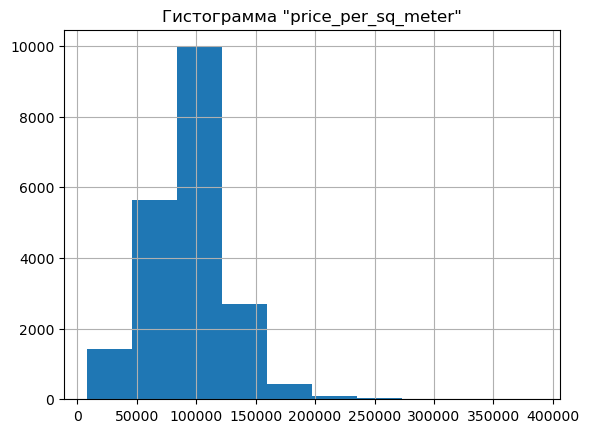

In [41]:
df['price_per_sq_meter'] = df['last_price'] / df['total_area']
plt.title('Гистограмма "price_per_sq_meter"')
df['price_per_sq_meter'].hist();

**День, месяц, год публикации объявления**

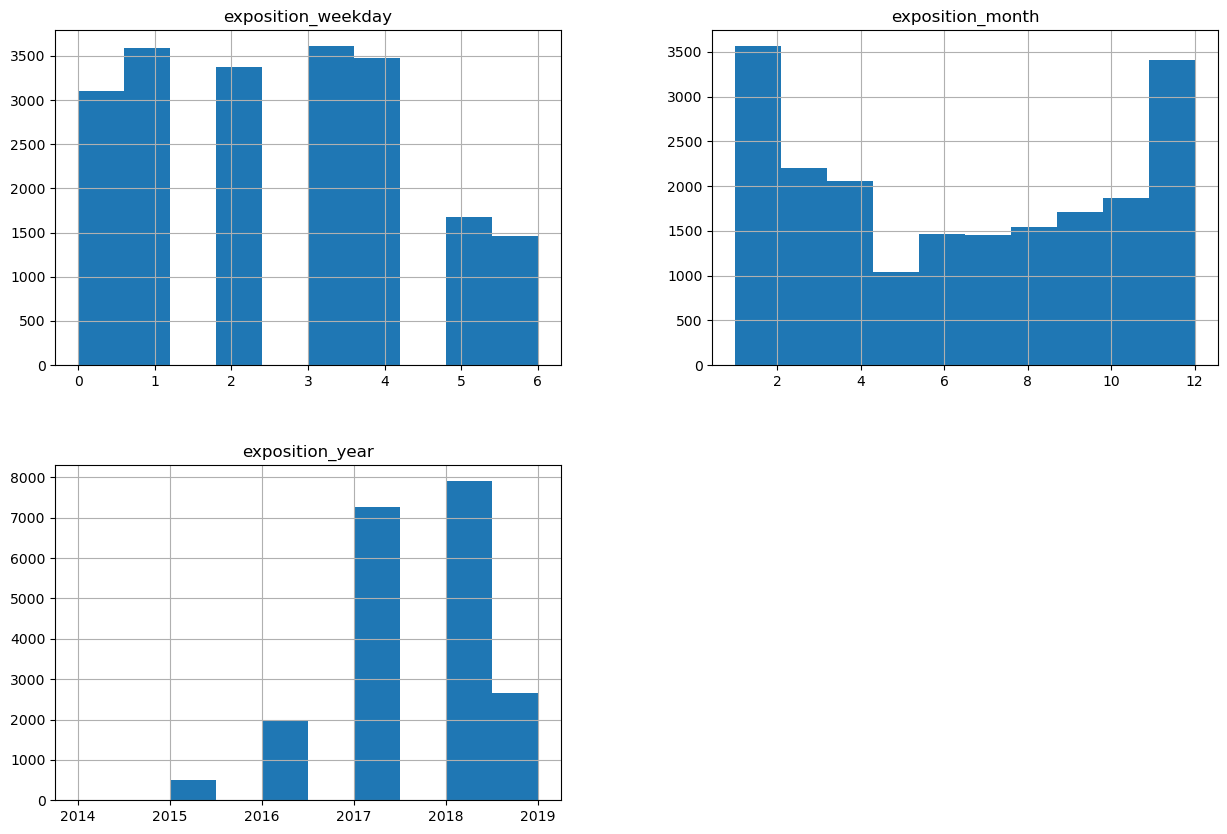

In [42]:
df['exposition_weekday'] = pd.DatetimeIndex(df['first_day_exposition']).weekday
df['exposition_month'] = pd.DatetimeIndex(df['first_day_exposition']).month
df['exposition_year'] = pd.DatetimeIndex(df['first_day_exposition']).year
df[['exposition_weekday', 'exposition_month', 'exposition_year']].hist(figsize=(15,10));

**Тип этажа квартиры (значения — «первый», «последний», «другой» <span style='color:red'> + «одноэтажка» </span>)**

In [43]:
def floor_type(row):
    if row['floor'] == 1 and row['floors_total'] == 1:
        return 'одноэтажка'
    elif row['floor'] == 1 and row['floors_total'] != 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

df['floor_type'] = df.apply(floor_type, axis=1)

# проверяем
df.pivot_table(values='floors_total', index=['floor_type', 'floor'], aggfunc=['count', 'max'])

count          max
                 floors_total floors_total
floor_type floor                          
другой     2             2717         28.0
           3             2406         28.0
           4             2076         28.0
           5             1133         28.0
           6              992         28.0
           7              989         27.0
           8              919         27.0
           9              579         27.0
           10             508         27.0
           11             449         27.0
           12             354         28.0
           13             311         28.0
           14             263         27.0
           15             285         28.0
           16             200         27.0
           17             164         27.0
           18             128         29.0
           19             101         27.0
           20              90         27.0
           21              99         27.0
           22              88         28.0
           23              73         28.0
           24              37         27.0
           25               8         27.0
           26              15         28.0
           27               1         28.0
одноэтажка 1               23          1.0
первый     1             2519         27.0
последний  2              166          2.0
           3              181          3.0
           4              256          4.0
           5             1089          5.0
           6               99          6.0
           7               60          7.0
           8               28          8.0
           9              359          9.0
           10              95         10.0
           11               6         11.0
           12             105         12.0
           13              17         13.0
           14              31         14.0
           15              20         15.0
           16              85         16.0
           17              35         17.0
           18              29         18.0
           19              17         19.0
           20               5         20.0
           21               5         21.0
           22              13         22.0
           23              14         23.0
           24              16         24.0
           25              25         25.0
           26               5         26.0
           27               7         27.0

**Расстояние в км до центра города**

In [44]:
df['city_centers_nearest_km'] = (df['city_centers_nearest'] / 1000).apply(lambda x: '{:.0f}'.format(x))
df['city_centers_nearest_km'] = pd.to_numeric(df['city_centers_nearest_km'], errors='coerce')

### Результаты добавления расчётных столбцов

Новые столбцы добавлены, их тип данных скорректирован. Добавлена категория "одноэтажка" в переменную с типом этажа.

## Исследовательский анализ данных

### Изучение и описание переменных

#### Площадь квартиры: общая, жилая, кухонная

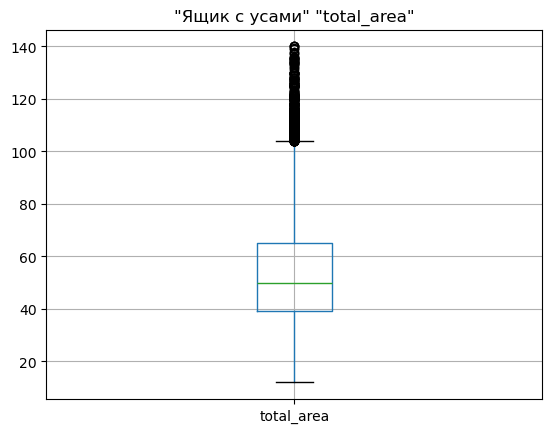

count    20295.000000
mean        54.100177
std         19.627937
min         12.000000
25%         39.065000
50%         50.000000
75%         65.000000
max        140.000000
Name: total_area, dtype: float64
cv = 2.76
range = 128.0


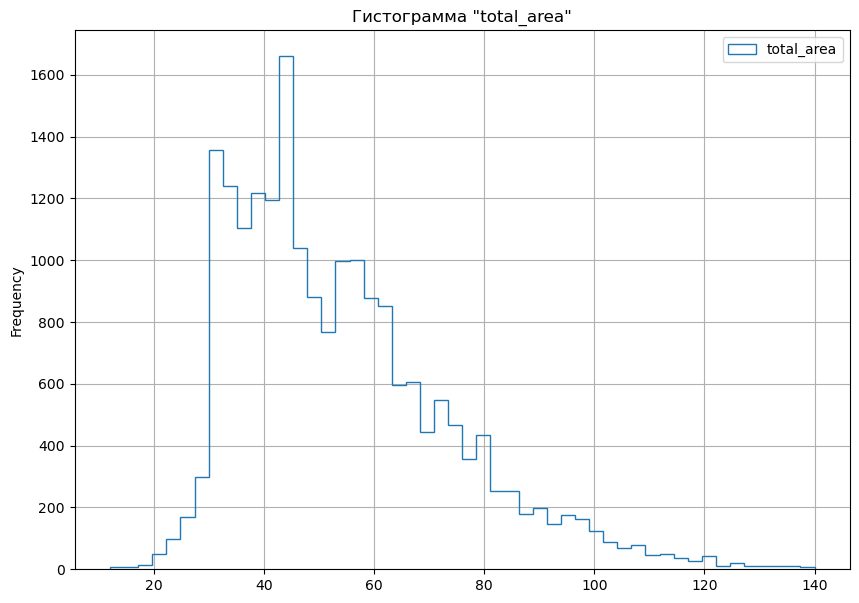

Разброс выборки большой, данные распределены не плотно (cv > 1).
Размах выборки равен 128.0 кв. м.

Среднее значение total_area равно 54.1 кв. м.

50 % значений переменной total_area принимают значения 50.0 кв. м и более (Q2).
50 % значений переменной total_area принимают значения от 39.065 (Q1) до 65.0 (Q3) кв. м (IQR).



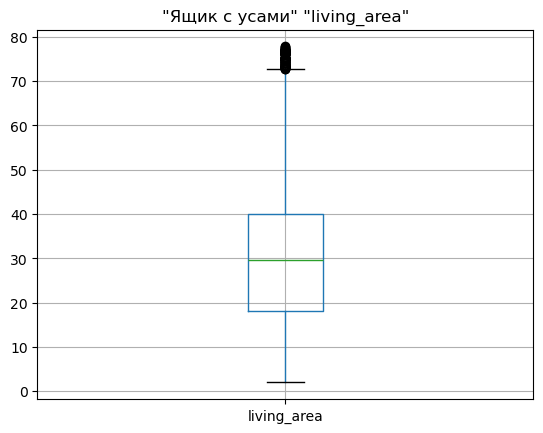

count    18660.000000
mean        30.931233
std         13.410663
min          2.000000
25%         18.200000
50%         29.600000
75%         40.000000
max         77.800000
Name: living_area, dtype: float64
cv = 2.31
range = 75.8


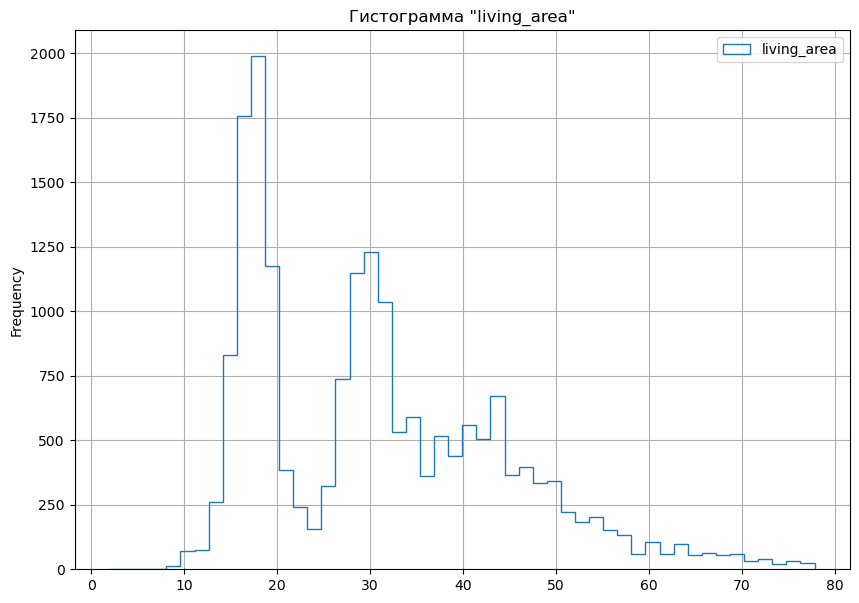

Разброс выборки большой, данные распределены не плотно (cv > 1).
Размах выборки равен 75.8 кв. м.

Среднее значение living_area равно 30.93 кв. м.

50 % значений переменной living_area принимают значения 29.6 кв. м и более (Q2).
50 % значений переменной living_area принимают значения от 18.2 (Q1) до 40.0 (Q3) кв. м (IQR).



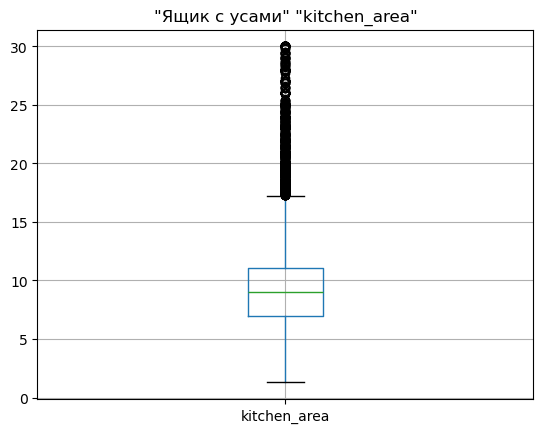

count    18334.000000
mean         9.727334
std          3.781542
min          1.300000
25%          7.000000
50%          9.000000
75%         11.100000
max         30.000000
Name: kitchen_area, dtype: float64
cv = 2.57
range = 28.7


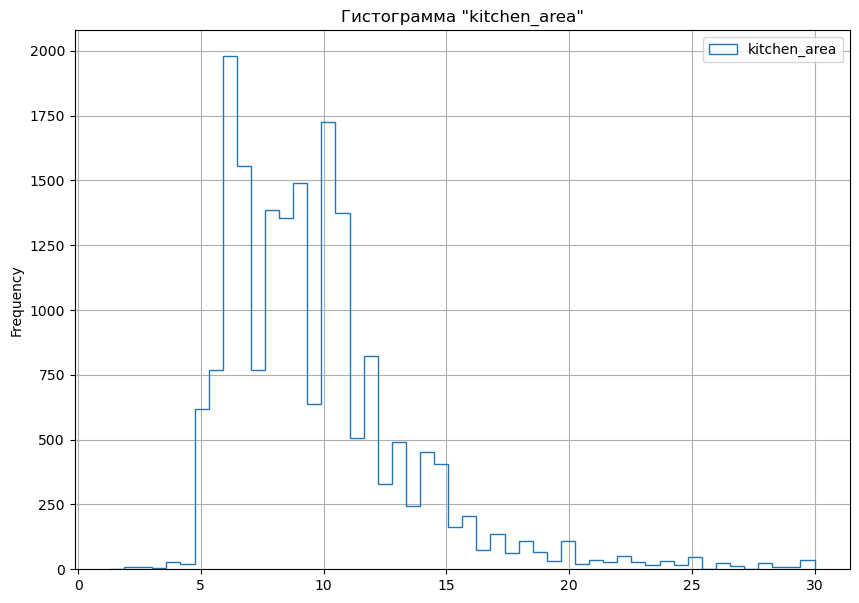

Разброс выборки большой, данные распределены не плотно (cv > 1).
Размах выборки равен 28.7 кв. м.

Среднее значение kitchen_area равно 9.73 кв. м.

50 % значений переменной kitchen_area принимают значения 9.0 кв. м и более (Q2).
50 % значений переменной kitchen_area принимают значения от 7.0 (Q1) до 11.1 (Q3) кв. м (IQR).



In [45]:
eda_list = ['total_area', 'living_area', 'kitchen_area']

for item in eda_list:
    plt.title(f'"Ящик с усами" "{item}"')
    df.boxplot(item)
    plt.show()
    print(df[item].describe())
    print('cv =', round(df[item].mean() / df[item].std(), 2))
    print('range =', df[item].max() - df[item].min())
    
    hist = df.plot(kind='hist', figsize=(10, 7), y=item, histtype='step', bins=50, label=item, title=f'Гистограмма "{item}"', grid=True)
    plt.show()
    
    mean = df[item].mean()
    q1 = df[item].quantile(0.25)
    q2 = df[item].quantile(0.50)
    q3 = df[item].quantile(0.75)
    iqr = q3 - q1
    
    result_text = f'Разброс выборки большой, данные распределены не плотно (cv > 1).\n' \
                  f'Размах выборки равен {df[item].max() - df[item].min()} кв. м.\n\n' \
                  f'Среднее значение {item} равно {round(mean, 2)} кв. м.\n\n' \
                  f'50 % значений переменной {item} принимают значения {q2} кв. м и более (Q2).\n' \
                  f'50 % значений переменной {item} принимают значения от {q1} (Q1) до {q3} (Q3) кв. м (IQR).'
    
    print(result_text)
    print()

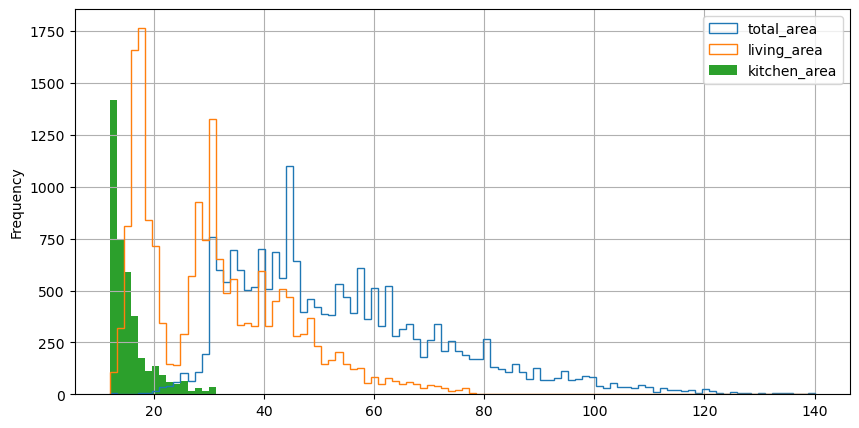

In [46]:
hist_total_area = df.plot(kind='hist',
                          y='total_area',
                          histtype='step',
                          bins=100,
                          label='total_area',
                          grid=True);

hist_living_area = df.plot(kind='hist',
                           y='living_area',
                           histtype='step',
                           range=(df['total_area'].min(), df['total_area'].max()),
                           bins=100,
                           label='living_area',
                           ax=hist_total_area,
                           grid=True,
                           legend=True);

hist_kitchen_area = df.plot(kind='hist',
                            figsize=(10,5),
                            y='kitchen_area',
                            range=(df['total_area'].min(), df['total_area'].max()),
                            bins=100,
                            label='kitchen_area',
                            ax=hist_living_area,
                            grid=True,
                            legend=True)

**Вывод по площадям**

Манера поведения данных по площадям похожа — смещённый влево пик, который говорит о распространённости минимально комфортного стандарта метража квартиры, жилой площади, кухни, и длинный хвост, в который попали статистически не достоверные значения, которые мы намеренно не удаляли на этапе предобработки данных.

Заметна бимодальность выборок. Так, например, есть два пика: в общей площади — 30 и 45, в жилой площади — 17 и 30 и в кухонной площади — 6 и 11 кв. м. Это не случайность, но проверка таких явлений требует более глубоко анализа.

#### Цена объекта

count    2.029500e+04
mean     5.138989e+06
std      2.828171e+06
min      4.300000e+05
25%      3.350000e+06
50%      4.500000e+06
75%      6.200000e+06
max      2.000000e+07
Name: last_price, dtype: float64
cv = 1.82
range = 19570000.0


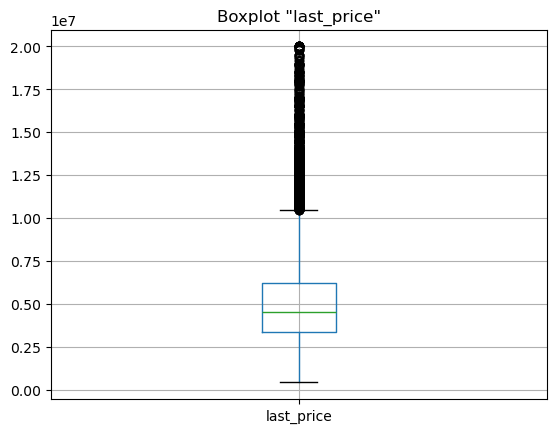

In [47]:
print(df['last_price'].describe())
# coefficient of variation (CV)
print('cv =', (round(df['last_price'].mean() / df['last_price'].std(), 2)))
# range
print('range =', df['last_price'].max() - df['last_price'].min())
plt.title('Boxplot "last_price"')
df.boxplot('last_price');

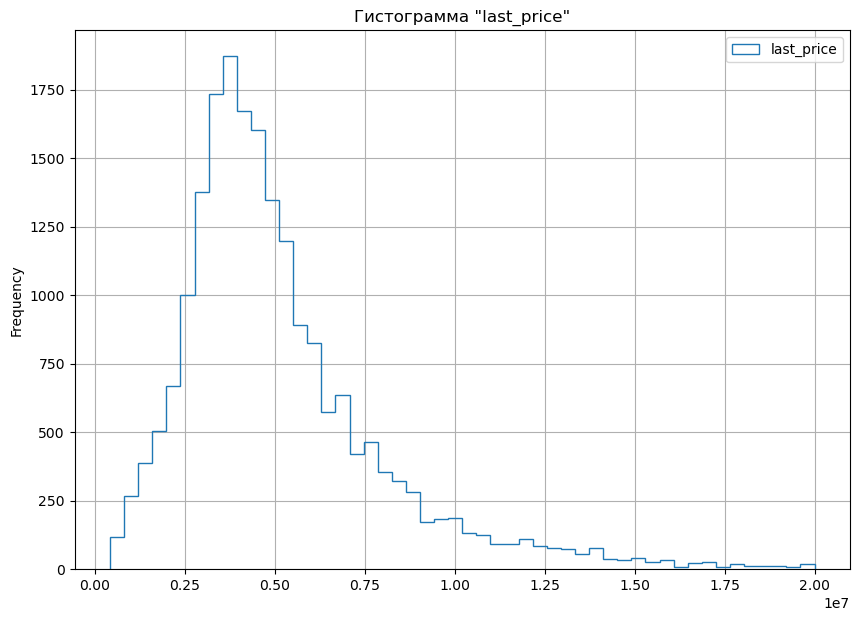

In [48]:
df.plot(kind='hist',
        figsize=(10,7),
        y='last_price',
        histtype='step',
        bins=50,
        label='last_price',
        title='Гистограмма "last_price"',
        grid=True);

Разброс выборки большой, данные распределены не плотно (cv > 1).
<br>Размах выборки равен 19,5 млн руб.

Среднее значение стоимости квартиры равно 5.1 млн руб. (сильно больше медианы, влияние выбросов)
<br>75 % квартир стоят 3,4 млн руб. и более (Q1).
<br>50 % квартир стоят 4.5 млн руб. и более (Q2).
<br>25 % квартир стоят 6.2 млн руб. и более (Q3).

50 % квартир стоят от 3.4 до 6.2 млн руб. (IQR).

#### Количество комнат

count    20295.000000
mean         1.944272
std          0.905127
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64
cv = 2.15
range = 7


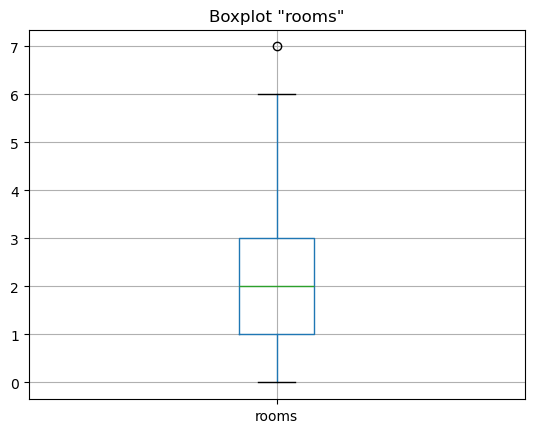

In [49]:
print(df['rooms'].describe())
# coefficient of variation (CV)
print('cv =', (round(df['rooms'].mean() / df['rooms'].std(), 2)))
# range
print('range =', df['rooms'].max() - df['rooms'].min())
plt.title('Boxplot "rooms"')
df.boxplot('rooms');

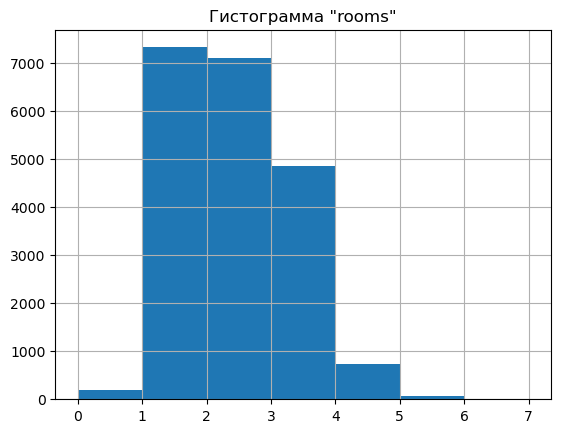

In [50]:
plt.title('Гистограмма "rooms"')
df['rooms'].hist(bins=7);

Напомню, что 0 комнат = студия.

Разброс выборки большой, данные распределены не плотно (cv > 1).
<br>Размах выборки равен 7 кв.

Среднее значение количества комнат равно 1.9 комнат.
<br>75 % квартир имеют 1 комнату и более (Q1).
<br>50 % квартир имеют 2 комнаты и более (Q2).
<br>25 % квартир имеют 3 комнаты и более (Q3).

50 % квартир имеют от 1 до 3 комнат (IQR).

#### Высота потолков

count    12318.000000
mean         2.693151
std          0.227439
min          2.400000
25%          2.500000
50%          2.600000
75%          2.750000
max          4.000000
Name: ceiling_height, dtype: float64
cv = 11.84
range = 1.6


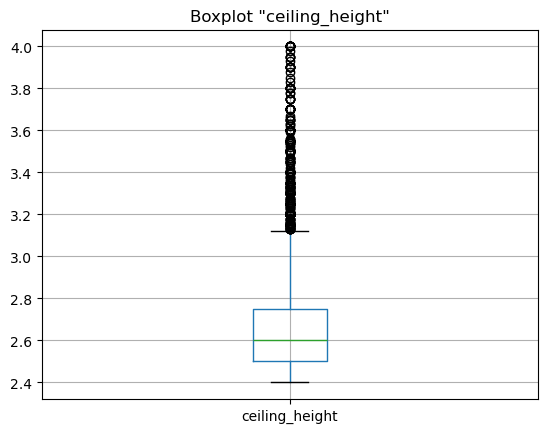

In [51]:
print(df['ceiling_height'].describe())
# coefficient of variation (CV)
print('cv =', (round(df['ceiling_height'].mean() / df['ceiling_height'].std(), 2)))
# range
print('range =', df['ceiling_height'].max() - df['ceiling_height'].min())
plt.title('Boxplot "ceiling_height"')
df.boxplot('ceiling_height');

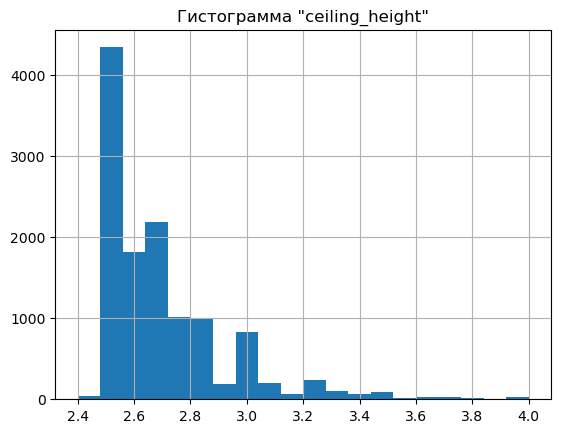

In [52]:
plt.title('Гистограмма "ceiling_height"')
df['ceiling_height'].hist(bins=20);

Разброс выборки большой, данные распределены очень не плотно (cv >> 1).
<br>Размах выборки равен 1.6 м.

Среднее значение высоты потолка равно 2.7 м.
<br>75 % квартир имеют высоту потолка 2.5 м и более (Q1).
<br>50 % квартир имеют высоту потолка 2.6 м и более (Q2).
<br>25 % квартир имеют высоту потолка 2.75 м и более (Q3).

50 % квартир имеют высоту потолка от 2.5 до 2.75 м (IQR).

#### Этаж квартиры

count    20295.000000
mean         5.915891
std          4.881302
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         27.000000
Name: floor, dtype: float64
cv = 1.21
range = 26


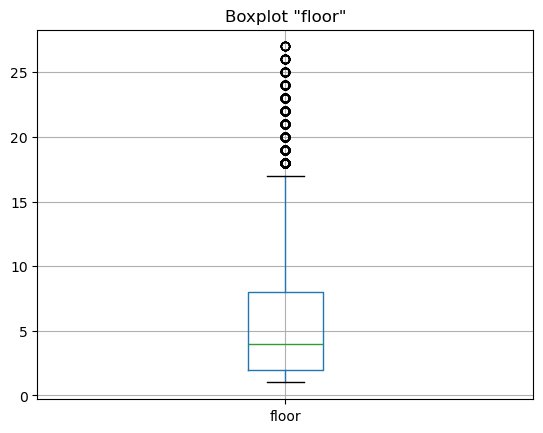

In [53]:
print(df['floor'].describe())
# coefficient of variation (CV)
print('cv =', (round(df['floor'].mean() / df['floor'].std(), 2)))
# range
print('range =', df['floor'].max() - df['floor'].min())
plt.title('Boxplot "floor"')
df.boxplot('floor');

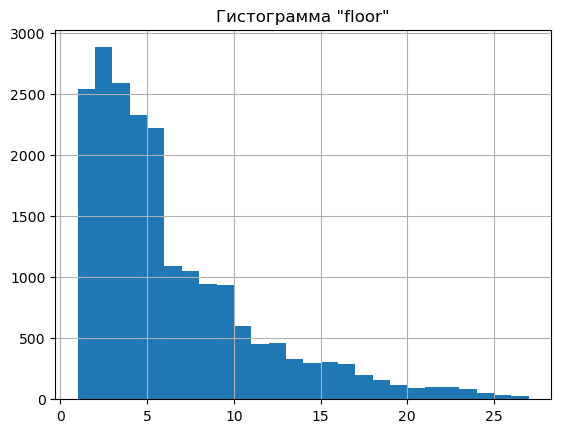

In [54]:
plt.title('Гистограмма "floor"')
df['floor'].hist(bins=26);

In [55]:
df.groupby('floor')['last_price'].count()

floor
1     2542
2     2883
3     2587
4     2332
5     2222
6     1091
7     1049
8      947
9      938
10     603
11     455
12     459
13     328
14     294
15     305
16     285
17     199
18     157
19     118
20      95
21     104
22     101
23      87
24      53
25      33
26      20
27       8
Name: last_price, dtype: int64

Разброс выборки небольшой, данные распределены плотно (cv ≈ 1).
<br>Размах выборки равен 26 этажей.

Среднее значение этажа квартиры равно 5.9.
<br>75 % квартир расположены на 2 этаже и более (Q1).
<br>50 % квартир расположены на 4 этаже и более (Q2).
<br>25 % квартир расположены на 8 этаже и более (Q3).

50 % квартир расположены от 2 до 8 этажа (IQR).

#### Тип этажа квартиры

In [56]:
print(df['floor_type'].describe())
df['floor_type'].value_counts()

count      20295
unique         4
top       другой
freq       14985
Name: floor_type, dtype: object


floor_type
другой        14985
последний      2768
первый         2519
одноэтажка       23
Name: count, dtype: int64

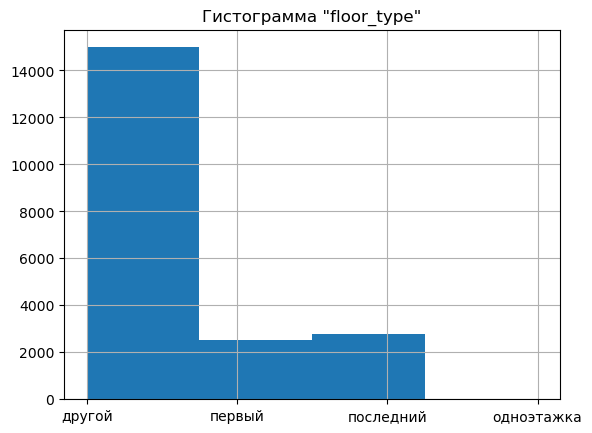

In [57]:
plt.title('Гистограмма "floor_type"')
df['floor_type'].hist(bins=4);

Доля первых этажей в объявлениях равна 12.4 %, доля последних этажей — 13.6 %. Одноэтажные дома занимают 0.1 % в объявлениях.

#### Общее количество этажей в доме

count    20295.000000
mean        10.840453
std          6.588031
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         29.000000
Name: floors_total, dtype: float64
cv = 1.65
range = 28.0


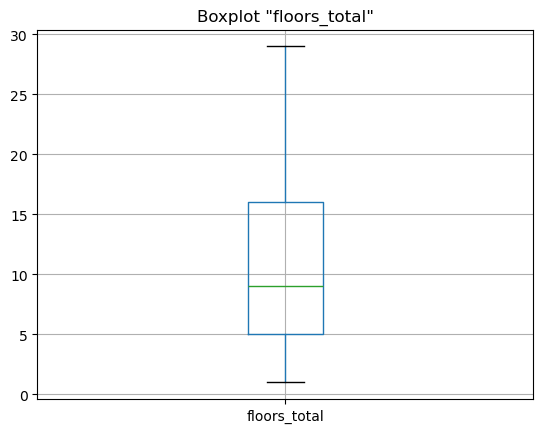

In [58]:
print(df['floors_total'].describe())
# coefficient of variation (CV)
print('cv =', (round(df['floors_total'].mean() / df['floors_total'].std(), 2)))
# range
print('range =', df['floors_total'].max() - df['floors_total'].min())
plt.title('Boxplot "floors_total"')
df.boxplot('floors_total');

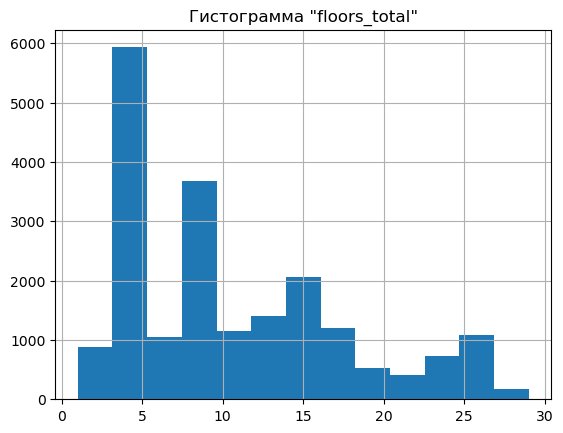

In [59]:
plt.title('Гистограмма "floors_total"')
df['floors_total'].hist(bins=13);

In [60]:
df.groupby('floors_total')['last_price'].count()

floors_total
1.0       23
2.0      331
3.0      535
4.0      953
5.0     4980
6.0      642
7.0      410
8.0      257
9.0     3426
10.0    1006
11.0     149
12.0    1210
13.0     189
14.0     505
15.0     320
16.0    1237
17.0     748
18.0     447
19.0     307
20.0     227
21.0     142
22.0     261
23.0     318
24.0     412
25.0     968
26.0     112
27.0     159
28.0      20
29.0       1
Name: last_price, dtype: int64

Разброс выборки большой, данные распределены не плотно (cv > 1).
<br>Размах выборки равен 28 этажам.

Среднее значение этажей в доме равно 10.8.
<br>75 % домов имеют 5 этажей и более (Q1).
<br>50 % домов имеют 9 этажей и более (Q2).
<br>25 % домов имеют 16 этажей и более (Q3).

50 % домов имеют от 5 до 16 этажей (IQR).

#### Расстояние до центра города в метрах

count    15179.000000
mean     14176.451874
std       7119.658884
min        208.000000
25%      10337.000000
50%      13355.000000
75%      16298.500000
max      39936.000000
Name: city_centers_nearest, dtype: float64
cv = 1.99
range = 39728.0


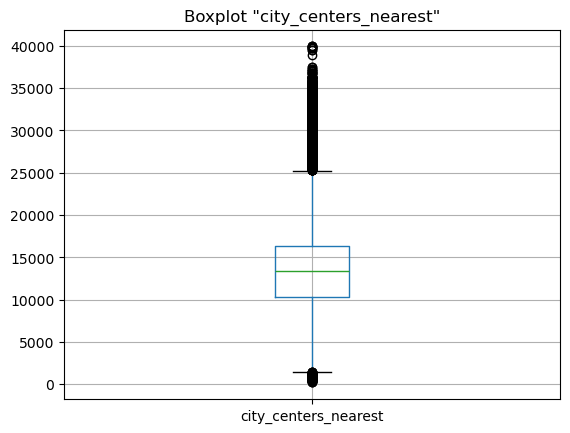

In [61]:
print(df['city_centers_nearest'].describe())
# coefficient of variation (CV)
print('cv =', (round(df['city_centers_nearest'].mean() / df['city_centers_nearest'].std(), 2)))
# range
print('range =', df['city_centers_nearest'].max() - df['city_centers_nearest'].min())
plt.title('Boxplot "city_centers_nearest"')
df.boxplot('city_centers_nearest');

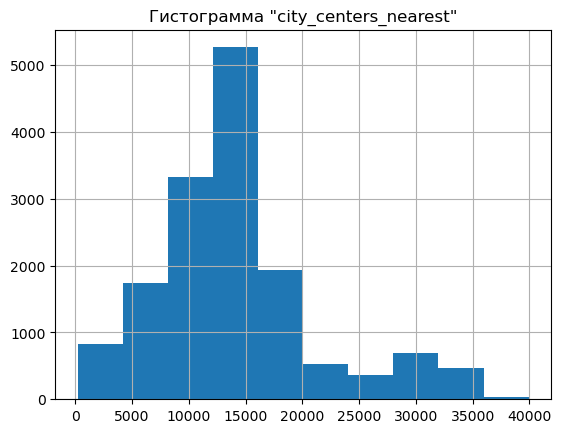

In [62]:
plt.title('Гистограмма "city_centers_nearest"')
df['city_centers_nearest'].hist();

Разброс выборки большой, данные распределены не плотно (cv > 1).
<br>Размах выборки равен 39728 м.

Среднее значение расстояния до центра СПб равно 14177 м.
<br>75 % квартир находятся на расстоянии 10337 м и более (Q1).
<br>50 % квартир находятся на расстоянии 13355 м и более (Q2).
<br>25 % квартир находятся на расстоянии 16299 м и более (Q3).

50 % квартир находятся на расстоянии от 10337 до 16299 м (IQR).

#### Расстояние до ближайшего аэропорта

count    15162.000000
mean     28574.527701
std      12438.369567
min       6450.000000
25%      18050.500000
50%      27006.000000
75%      37197.000000
max      61748.000000
Name: airports_nearest, dtype: float64
cv = 2.3
range = 55298.0


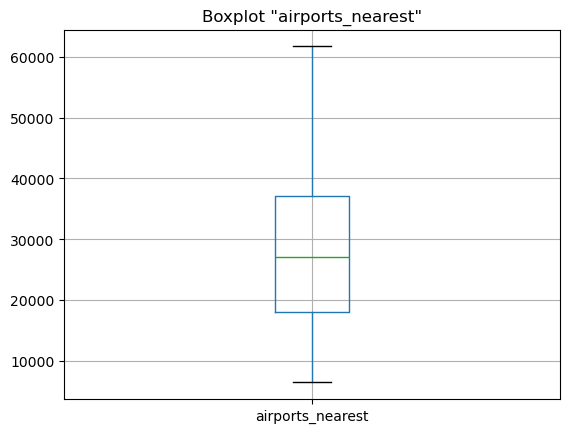

In [63]:
print(df['airports_nearest'].describe())
# coefficient of variation (CV)
print('cv =', (round(df['airports_nearest'].mean() / df['airports_nearest'].std(), 2)))
# range
print('range =', df['airports_nearest'].max() - df['airports_nearest'].min())
plt.title('Boxplot "airports_nearest"')
df.boxplot('airports_nearest');

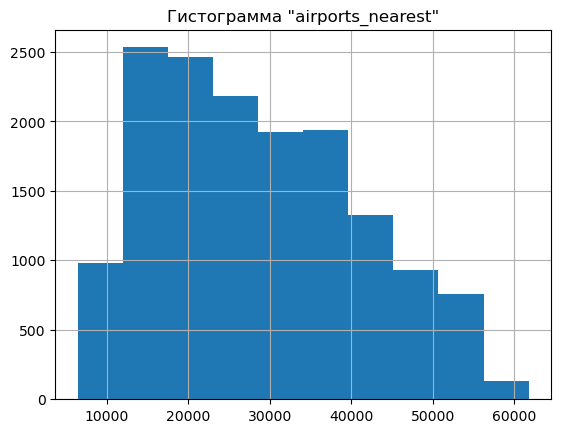

In [64]:
plt.title('Гистограмма "airports_nearest"')
df['airports_nearest'].hist();

Разброс выборки большой, данные распределены не плотно (cv > 1).
<br>Размах выборки равен 55298 м.

Среднее значение расстояния до аэропорта равно 28574 м.
<br>75 % квартир находятся на расстоянии 18050 м и более (Q1).
<br>50 % квартир находятся на расстоянии 27006 м и более (Q2).
<br>25 % квартир находятся на расстоянии 37197 м и более (Q3).

50 % квартир находятся на расстоянии от 18050 до 37197 м (IQR).

#### Расстояние до ближайшего парка

In [65]:
# посмотрим, какие данные есть

display(df.pivot_table(values='parks_nearest',
                       index='locality_name',
                       aggfunc=['min', 'mean'],
                       dropna=True
                      )
       )

,min,mean
,parks_nearest,parks_nearest
locality_name,,
Колпино,49.0,362.885965
Красное Село,23.0,461.097561
Павловск,105.0,376.458333
Петергоф,13.0,313.026087
Пушкин,11.0,405.104396
Санкт-Петербург,1.0,452.712668
Сестрорецк,77.0,386.015625
посёлок Парголово,30.0,501.100000


count    6306.000000
mean      446.568506
std       216.462755
min         1.000000
25%       287.000000
50%       448.000000
75%       598.000000
max      1098.000000
Name: parks_nearest, dtype: float64
cv = 2.06
range = 1097.0


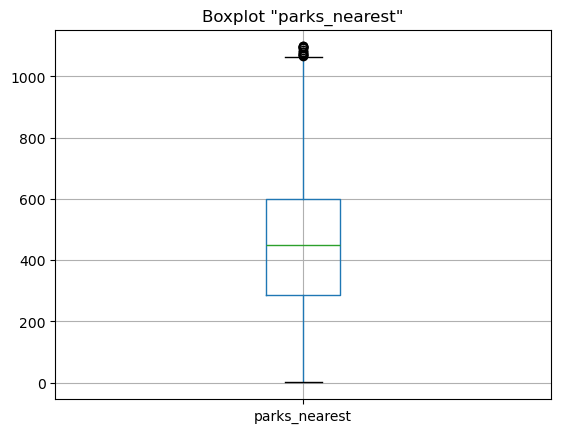

In [66]:
print(df['parks_nearest'].describe())
# coefficient of variation (CV)
print('cv =', (round(df['parks_nearest'].mean() / df['parks_nearest'].std(), 2)))
# range
print('range =', df['parks_nearest'].max() - df['parks_nearest'].min())
plt.title('Boxplot "parks_nearest"')
df.boxplot('parks_nearest');

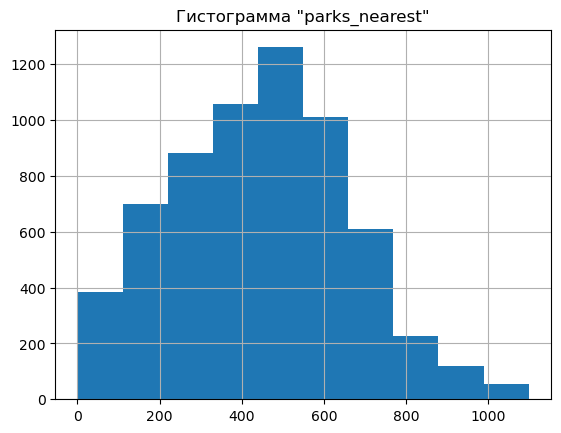

In [67]:
plt.title('Гистограмма "parks_nearest"')
df['parks_nearest'].hist();

Разброс выборки большой, данные распределены не плотно (cv > 1).
<br>Размах выборки равен 1097 м.

Среднее значение расстояния до парка равно 446 м.
<br>75 % квартир находятся на расстоянии 287 м до парка и более (Q1).
<br>50 % квартир находятся на расстоянии 448 м до парка и более (Q2).
<br>25 % квартир находятся на расстоянии 597 м до парка и более (Q3).

50 % квартир находятся на расстоянии от 287 до 507 м до парка (IQR).

Данные не репрезентативны.

#### День и месяц публикации объявления

In [68]:
print(df['exposition_weekday'].describe())
df['exposition_weekday'].value_counts().sort_values()

count    20295.000000
mean         2.575018
std          1.794145
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: exposition_weekday, dtype: float64


exposition_weekday
6    1465
5    1677
0    3098
2    3378
4    3478
1    3590
3    3609
Name: count, dtype: int64

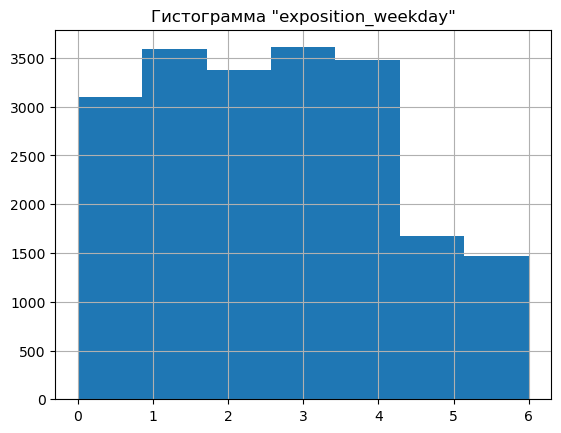

In [69]:
plt.title('Гистограмма "exposition_weekday"')
df['exposition_weekday'].hist(bins=7);

In [70]:
print(df['exposition_month'].describe())
df['exposition_month'].value_counts()

count    20295.000000
mean         6.406406
std          3.490233
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: exposition_month, dtype: float64


exposition_month
2     2285
3     2200
4     2057
11    2049
10    1863
9     1712
8     1541
6     1461
7     1451
12    1360
1     1277
5     1039
Name: count, dtype: int64

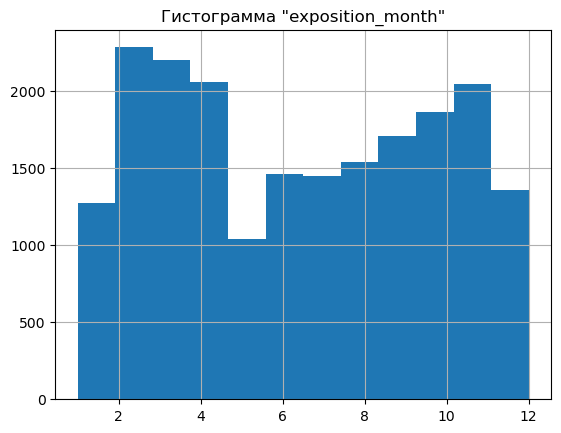

In [71]:
plt.title('Гистограмма "exposition_month"')
df['exposition_month'].hist(bins=12);

Самыми популярными днями недели для публикации объявления о продаже квартиры являются дни от вторника до пятницы, где во вторник выкладывается больше всего объявлений. На выходных выкладывается в два раза меньше объявлений, что я не могу логически обосновать.

Самыми популярными месяцами для публикации объявлений о продаже квартиры является февраль. Самым непопулярным месяцес является май. С февраля по апрель включительно заметна наибольшая активность продавцов.Далее активность падает в два раза и к ноябрю постепенно нарастает до апрельского уровня. В декабре и январе происходит спад, после чего в февраля начинается новый цикл активности.

### Насколько быстро продаются квартиры? ###

count    17543.000000
mean       128.808927
std        123.984462
min          1.000000
25%         41.000000
50%         83.000000
75%        181.000000
max        540.000000
Name: days_exposition, dtype: float64
cv = 1.04
range = 539.0


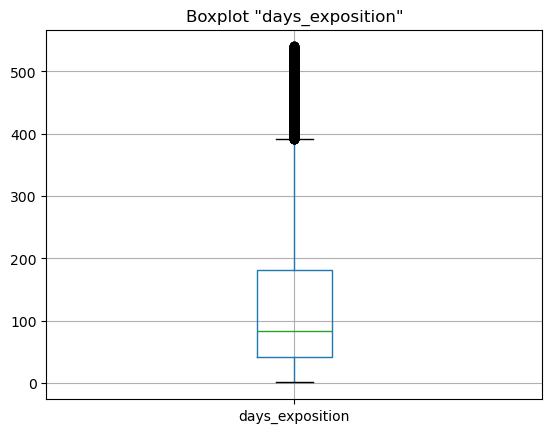

In [72]:
print(df['days_exposition'].describe())
# coefficient of variation (CV)
print('cv =', (round(df['days_exposition'].mean() / df['days_exposition'].std(), 2)))
# range
print('range =', df['days_exposition'].max() - df['days_exposition'].min())
plt.title('Boxplot "days_exposition"')
df.boxplot('days_exposition');

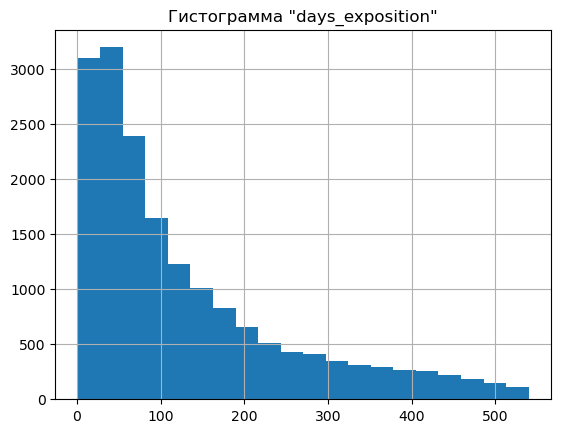

In [73]:
plt.title('Гистограмма "days_exposition"')
df['days_exposition'].hist(bins=20);

Разброс выборки небольшой, данные распределены плотно (cv ≈ 1).
<br>Размах выборки равен 530 дней.

**Среднее значение** кол-ва дней активного объявления равно 128 дней.
<br>75 % объявлений закрылись через 41 день и более (Q1).
<br>50 % объявлений закрылись через 83 дня и более (**медиана**).
<br>25 % объявлений закрылись через 180 дней и более(Q3).

50 % объявлений были активными от 41 до 180 дней (IQR).

Быстрыми продажами можно считать те продажи, которые были осуществлены до 41 дня с момента публикации; долгими продажами можно считать продажи, которые были осуществлены после 180 дней с момента публикации.

### Какие факторы больше всего влияют на стоимость квартиры? ###
Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы:
- общей площади;
- жилой площади;
- площади кухни;
- количество комнат;
- типа этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).

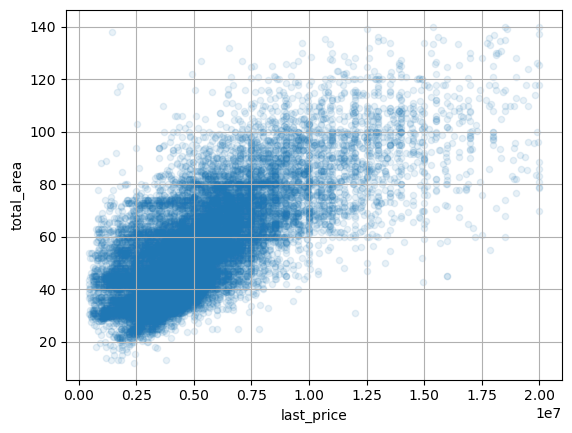

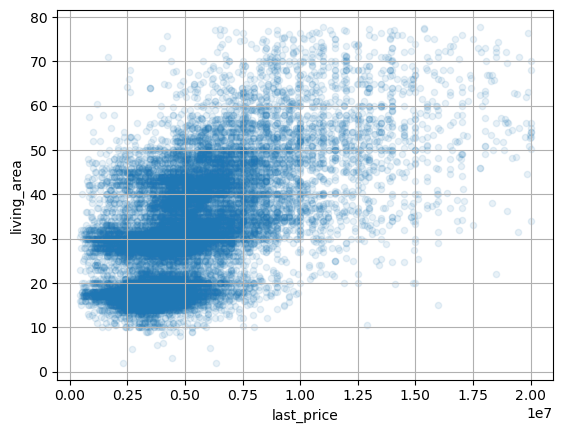

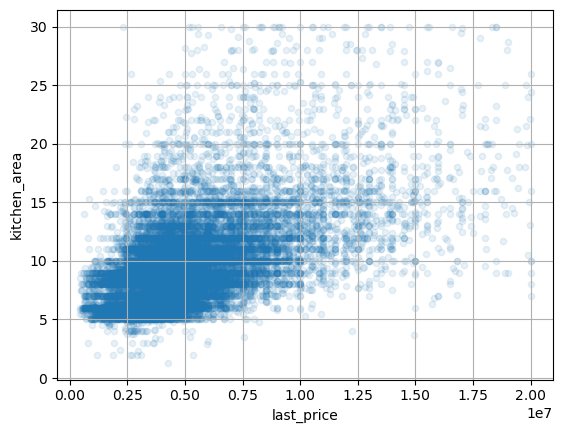

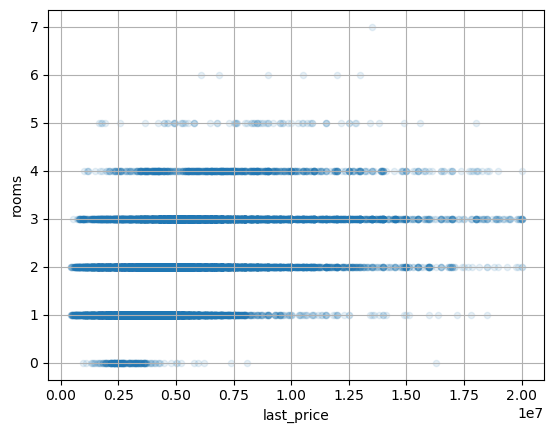

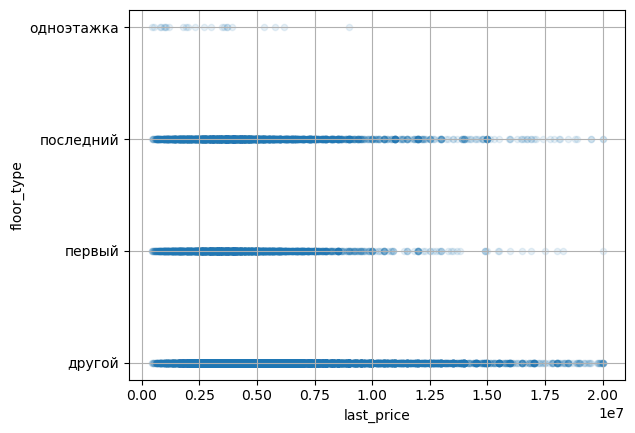

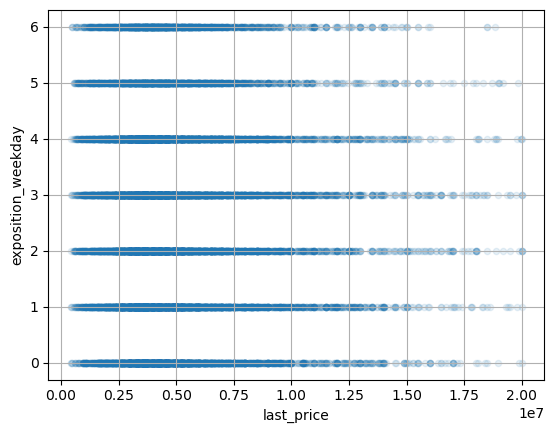

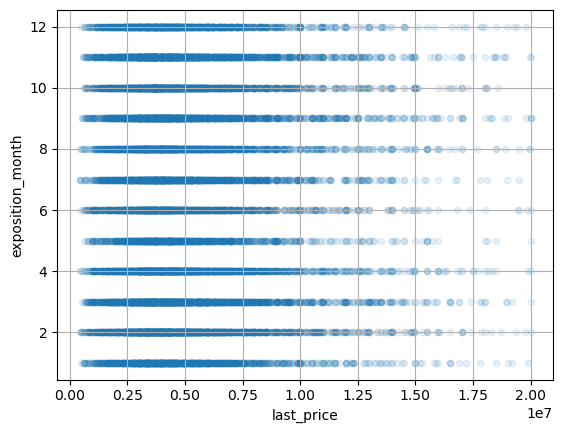

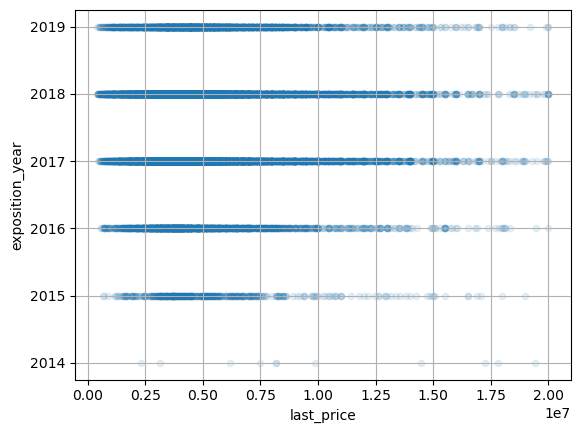

In [74]:
# создадим цикл для последовательного построения точечной диаграммы м
for column in df[['total_area', 'living_area', 'kitchen_area',
                  'rooms', 'floor_type', 'exposition_weekday',
                  'exposition_month', 'exposition_year']]:
    df.plot(x='last_price',
            y=column,
            kind='scatter',
            grid=True,
            alpha=0.1
           )

Визуально связь с переменной 'last_price' заметна у переменной 'total_area', 'living_area'.

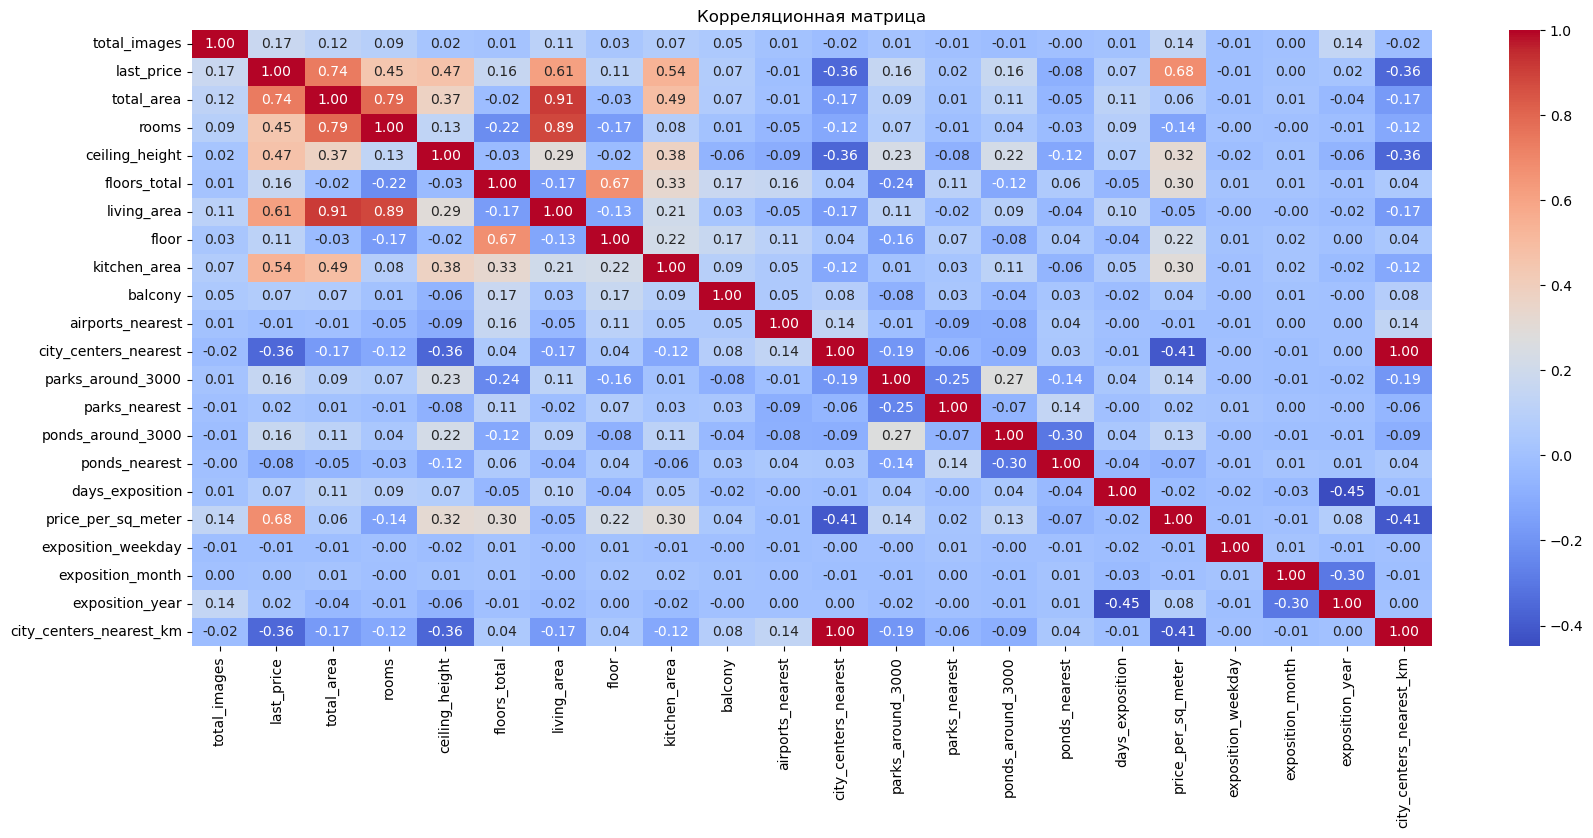

In [75]:
# выведем корреляционную матрицу для всех переменных в формате тепловой карты

plt.figure(figsize=(20, 8))  # Задаем размер графика
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Корреляционная матрица')
plt.show()

Наибольшее значение коэффициента корреляции Пирсона с переменной 'last_price' наблюдается у переменных:
- 'total_area', r = 0.74
- 'living_area', r = 0.61
- 'price_per_sq_meter', r = 0.68 (однозначно выведенная из 'last_price' переменная, поэтому не важнно)

Таким образом, главным параметром стоимости квартиры является её общая площадь.

### Какова средняя цена 1 кв. метра в 10 населённых пунктах с наибольшим числом объявлений? ###
Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра.
Эти данные можно найти по имени в столбце locality_name."

In [76]:
# для 10 населённых пунктов в наибольшим числом объявлений покажем среднюю стоимость квадратного метра 

(df
 [df['locality_name']
    .isin(df['locality_name']
          .value_counts()
          .sort_values(ascending=False)
          .head(10)
          .index)
   ]
 .groupby('locality_name')['price_per_sq_meter']
 .mean()
 .sort_values(ascending=False))

locality_name
Санкт-Петербург      108322.647783
Пушкин               101569.254186
Кудрово               95604.186719
посёлок Парголово     90043.831501
Мурино                86247.121320
посёлок Шушары        78547.891908
Колпино               75263.414211
Гатчина               68966.712674
Всеволожск            67171.849471
Выборг                58182.995937
Name: price_per_sq_meter, dtype: float64

In [77]:
# покажем 10 населённых пунктов с самой низкой средней стоимостью квадратного метра

(df
 .groupby('locality_name')['price_per_sq_meter']
 .mean()
 .sort_values(ascending=False)
 .tail(10))

locality_name
деревня Ям-Тесово          13711.553373
деревня Сижно              13709.677419
деревня Бор                13157.894737
посёлок Тёсово-4           12931.034483
деревня Малая Романовка    12724.550898
посёлок Совхозный          12629.129129
деревня Выскатка           12335.480902
деревня Вахнова Кара       11688.311688
посёлок станции Свирь      11481.481481
деревня Старополье         11206.221198
Name: price_per_sq_meter, dtype: float64

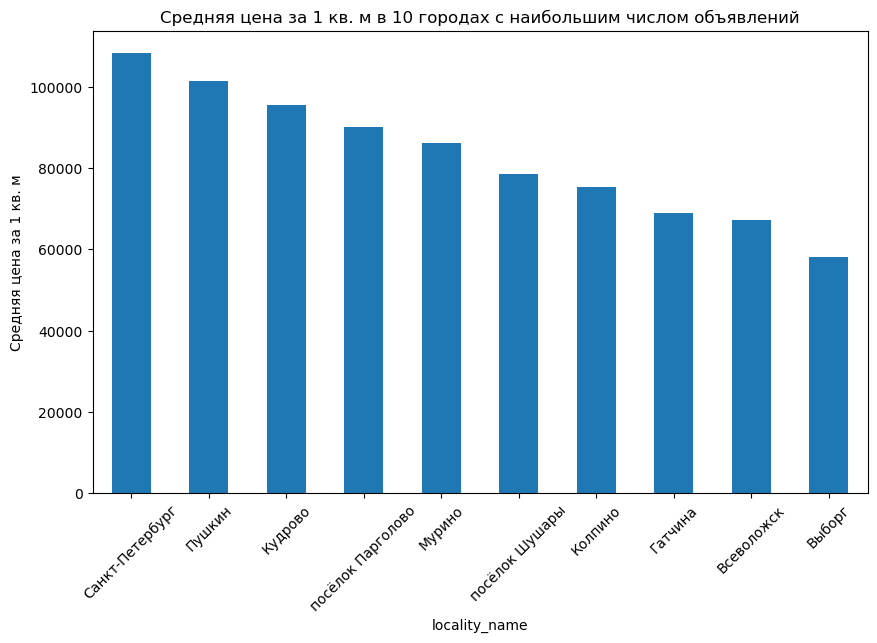

In [78]:
# для 10 населённых пунктов в наибольшим числом объявлений построим 
# столбчатую диаграмму средней стоимости кв. метра 
top_10_price = (df.groupby('locality_name')['price_per_sq_meter'].mean()
                .loc[df['locality_name'].value_counts().head(10).index])

plt.figure(figsize=(10, 6))
top_10_price_sorted = top_10_price.sort_values(ascending=False)
top_10_price_sorted.plot(kind='bar')
plt.title('Средняя цена за 1 кв. м в 10 городах с наибольшим числом объявлений')
plt.xlabel('locality_name')
plt.ylabel('Средняя цена за 1 кв. м')
plt.xticks(rotation=45)
plt.show()

Самый дорого кв. м жилья, очевидно, в Санкт-Петербурге. Потом идёт Пушкин. Кудрово дороже Мурино, что интересно -- противостояние двух "муравейников".

### Какова средняя цена квартир в Санкт-Петербурге в зависимости от удалённости от центра? ###

city_centers_nearest_km
0.0    8,798,000.0
1.0    9,712,453.0
2.0    9,176,371.0
3.0    8,167,941.0
4.0    8,630,670.0
5.0    8,754,618.0
6.0    8,109,874.0
7.0    7,582,581.0
8.0    7,310,781.0
9.0    6,031,392.0
10.0   5,813,829.0
11.0   5,552,930.0
12.0   5,588,018.0
13.0   5,831,962.0
14.0   5,452,000.0
15.0   5,543,015.0
16.0   5,202,111.0
17.0   4,945,438.0
18.0   4,597,875.0
19.0   5,017,439.0
20.0   4,611,579.0
21.0   5,467,404.0
22.0   5,265,101.0
23.0   4,670,462.0
24.0   3,835,887.0
25.0   4,052,840.0
26.0   4,014,287.0
27.0   2,250,000.0
28.0   5,026,429.0
29.0   4,210,000.0
Name: last_price, dtype: float64


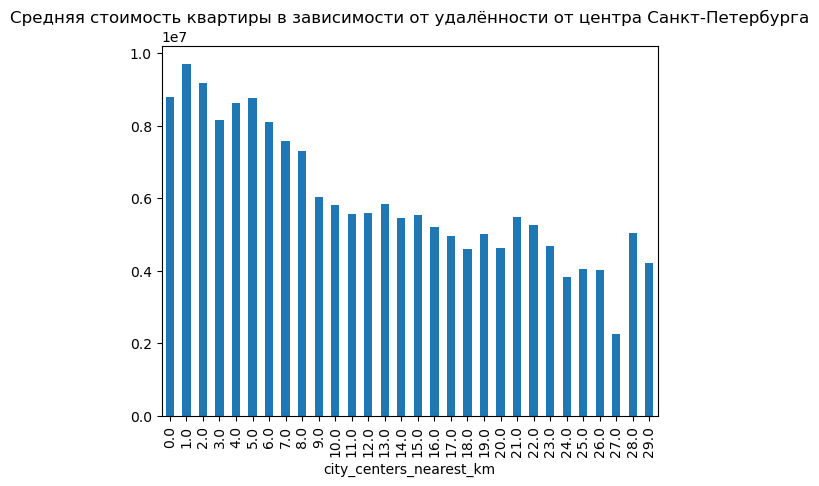

In [79]:
price_per_km = (df[df['locality_name'] == 'Санкт-Петербург']
                .groupby('city_centers_nearest_km')['last_price']
                .mean().sort_index().round())
pd.options.display.float_format = '{:,}'.format
print(price_per_km)
plt.title('Средняя стоимость квартиры в зависимости от удалённости от центра Санкт-Петербурга')
price_per_km.plot(kind='bar');

У стоимости объектов и отдалённости от центра обратная прямая связь. В самом центре квартиры в среднем стоят 2-9 млн, а за 29 км до центра -- 4-5 млн.

## Общий вывод

В ходе работы над проектом были проделаны следующие действия:
- Данные были подготовлены к анализу (обработаны пропуски в данных, изменены типы данных, обработаны дубликаты, обработаны аномальные значения)
- Данные были обогащены новыми расчётными столбцами
- При исследовательском анализе данных посчитаны описательные статистики, построен гистограммы и "ящики с усами"
- Были получены ответы на конкретные вопросы бизнеса (1.5.2 - 1.5.5)

Были сделаны следующие выводы:
- Заметна бимодальность выборок по общей, жилой и кухонной площадям. Так, например, есть два пика: в общей площади — 30 и 45, в жилой площади — 17 и 30 и в кухонной площади — 6 и 11 кв. м. Это можно объяснить типичными планировками и нормами, но предугадать такое явление было сложно;
- Только 25 % квартир стоят дешевле 3,4 млн руб. и только 25 % квартира стоят дороже 6.2 млн руб. С одной стороны, выбор дешёвых квартир (до 2 млн руб.) был ограничен, с другой стороны, потолок цен был сильно ниже;
- Распределение числа комнат в квартирах получилось достаточно равномерным (1, 2, 3 комнаты занимают примерно по четверти выборки на каждый случай), что говорит о равномерной застройке квартир в Санкт-Петербурге в плане количества комнат;
- Только в 25 % квартир высота потолка больше 2.75 м;
- Больше всего продаётся квартир на втором этаже. Из распределения видно, что в выборке много пятиэтажек;
- В Санкт-Петербурге распространены 5-, 9-, 16- этажные дома
- Самыми популярными днями недели для публикации объявления о продаже квартиры являются дни от вторника до пятницы, где во вторник выкладывается больше всего объявлений. На выходных выкладывается в два раза меньше объявлений;
- Самыми популярными месяцами для публикации объявлений о продаже квартиры является февраль. Самым непопулярным месяцес является май. С февраля по апрель включительно заметна наибольшая активность продавцов. Далее активность падает в два раза и к ноябрю постепенно нарастает до апрельского уровня. В декабре и январе происходит спад, после чего в февраля начинается новый цикл активности;
- Половина квартир продаётся менее чем за 3 месяца;
- Больше всего на стоимость квартиры влияет её общая площадь;
- Пушкин является неожиданно (для меня) дорогим районом Санкт-Петербурга